In [1]:
import quantum_kan 
import symengine as se
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import mean_squared_error, r2_score
from pyqubo import Binary, Array
import os
from dwave.embedding.chain_breaks import majority_vote
from dimod import BinaryQuadraticModel
import dwave.inspector
# Solve the QUBO using a quantum annealer
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler, FixedEmbeddingComposite
from dwave.embedding.chain_strength import uniform_torque_compensation
import time 
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
from qkan import KAN
import torch.nn as nn
import minorminer
import networkx as nx

# Set your D-Wave API token
import os
# env_vars = !cat dwave.env
# for var in env_vars:
#     key, value = var.split('=')
#     os.environ[str(key)] = str(value)
# #Advantage_system6.4 or Advantage2_prototype2.3
# # sampler = EmbeddingComposite(DWaveSampler(solver='Advantage2_prototype2.3'))
# sampler = LeapHybridSampler(solver="hybrid_binary_quadratic_model_version2")

simulated_sampler = SimulatedAnnealingSampler()

# Set the number of threads for intra-op parallelism (used for CPU operations)
torch.set_num_threads(1)

# Set the number of threads for inter-op parallelism (used for parallelism between operations)
torch.set_num_interop_threads(1)

# Verify the settings
print(f"Number of intra-op threads: {torch.get_num_threads()}")
print(f"Number of inter-op threads: {torch.get_num_interop_threads()}")


Number of intra-op threads: 1
Number of inter-op threads: 1


In [2]:
def convert_sympy_to_pyqubo(objective_func, conversion_dict):
    # Parse the simplified symbolic equation and update the QUBO matrix
    
    expression = mse_with_penalty_str
    pyqubo_expr = 0
    # Replace '-' with '+-' to simplify splitting
    expression = expression.replace(' - ', ' + -')
    # Split the expression into terms
    terms = expression.split(' + ')
    pyqubo_obj = 0

    for term in terms:
        # Split term into coefficient and variable parts
        parts = term.split('*')
        current_pyqubo_term = int(0)
        first_var = True
        for part in parts:
            if ('P' in part) or ('AUX' in part):
                current_pyqubo_var = conversion_dict.get(part)
            else:
                current_pyqubo_var = float(part)
                
            if first_var:
                current_pyqubo_term = current_pyqubo_var
                first_var = False
            else:
                current_pyqubo_term = current_pyqubo_term * current_pyqubo_var
        # current_pyqubo_term = current_pyqubo_term * coeff
        pyqubo_obj += current_pyqubo_term
        del current_pyqubo_term
        
    return pyqubo_obj

# Define the Bernstein polynomial basis functions
def bernstein_basis_functions(x, degree):
    """
    Calculates the Bernstein polynomial basis functions.

    Args:
        x (array-like): Points at which to evaluate the basis functions.
        degree (int): Degree of the Bernstein polynomial.

    Returns:
        numpy.ndarray: A 2D array of shape (n_basis, len(x)), where each row 
                       represents a basis function evaluated at the points in x.
    """
    n = degree
    basis = np.zeros((n+1, len(x)))

    for i in range(n+1):
        binomial_coeff = math.comb(n, i)
        basis[i, :] = binomial_coeff * (x**i) * ((1 - x)**(n - i))

    return basis

def bernstein_poly(i, n, t):
    """Compute the Bernstein polynomial B_i^n at t."""
    return comb(n, i) * (t ** i) * ((1 - t) ** (n - i))

def bezier_curve(coefficients, t):
    """Compute a Bezier curve given coefficients and parameter t."""
    n = len(coefficients) - 1
    return sum(coefficients[i] * bernstein_poly(i, n, t) for i in range(n + 1))

# Normalize x_data and y_data
def normalize(data):
    data_min, data_max = data.min(), data.max()
    return (data - data_min) / (data_max - data_min)


# Define a custom base function that always returns zero
class ZeroBaseFunction(nn.Module):
    def forward(self, x):
        return torch.zeros_like(x)
    
def separate_vars(solution):
    """
    Separate coefficients and auxiliary variables from the solution dictionary.

    :param solution: The solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {k: v for k, v in solution.items() if k.startswith('aux')}
    coeff_vars = {k: v for k, v in solution.items() if k.startswith('coeff')}
    
    return aux_vars, coeff_vars

def create_reverse_lookup_dict(original_dict):
    """
    Create a reverse lookup dictionary from the given dictionary.

    :param original_dict: The original dictionary to reverse.
    :return: A new dictionary where keys are the original values and values are the original keys.
    """
    reverse_dict = {v: k for k, v in original_dict.items()}
    return reverse_dict

def map_solution_variables(solution, reverse_dict):
    """
    Map solution variables from PyQUBO to SymPy using the reverse dictionary.

    :param solution: The solution dictionary with PyQUBO variables.
    :param reverse_dict: The reverse lookup dictionary to map PyQUBO variables to SymPy variables.
    :return: A new dictionary with SymPy variables as keys and solution values.
    """
    mapped_solution = {}
    for pyqubo_var, value in solution.items():
        sympy_var = reverse_dict.get(Binary(pyqubo_var))
        if sympy_var is not None:
            mapped_solution[sympy_var] = value
        else:
            print(f"Warning: PyQUBO variable {pyqubo_var} not found in reverse mapping.")
    return mapped_solution

def separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary=False):
    """
    Separate coefficients and auxiliary variables from the mapped solution dictionary.

    :param mapped_solution: The mapped solution dictionary containing both coefficients and auxiliary variables.
    :return: Two dictionaries, one for coefficients and one for auxiliary variables.
    """
    aux_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if str(k).replace('"','').replace("'","").startswith('AUX')}
    if include_aux_in_binary == True:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if  str(k).replace('"','').replace("'","")}
    else:
        binary_vars = {str(k).replace('"','').replace("'",""): v for k, v in mapped_solution.items() if not str(k).replace('"','').replace("'","").startswith('AUX')}
    
    return aux_vars, binary_vars

def check_aux_variables(binary_vars, aux_vars, aux_dict_all):
    """
    Check if auxiliary variables correctly represent the product of their respective binary variables.

    :param binary_vars: Dictionary of binary variable values (e.g., {'x1': 0, 'x2': 1, ...})
    :param aux_vars: Dictionary of auxiliary variable values (e.g., {'z1': 1, 'z2': 0, ...})
    :param aux_dict_all: Dictionary mapping auxiliary variables to their respective binary variable products
                         (e.g., {'z1': x1*x2, 'z2': x2*x3, ...})
    :return: Dictionary indicating whether each auxiliary variable is correct (e.g., {'z1': True, 'z2': False, ...})
    """
    results = {}

    for aux_var, aux_expr in aux_dict_all.items():
        # Extract the binary variables involved in the product
        vars_in_expr = aux_expr.split('*')
        product_value = 1
        aux_var = str(aux_var)

        # Calculate the expected value by multiplying the values of the binary variables
        for var in vars_in_expr:
            var = str(var)
            if var in binary_vars:
                product_value *= binary_vars[var]
            else:
                raise ValueError(f"Variable {var} not found in binary_vars dictionary")

        # Check if the auxiliary variable's value matches the expected product value
        if aux_var in aux_vars:
            results[aux_var] = (aux_vars[aux_var] == product_value)
        else:
            raise ValueError(f"Auxiliary variable {aux_var} not found in aux_vars dictionary")

    return results
    
def create_dataset(f, 
                   n_var=2, 
                   ranges = [0,1],
                   train_num=1000, 
                   test_num=1000,
                   normalize_input=True,
                   normalize_label=False,
                   device='cpu',
                   seed=0):
    '''
    create dataset
    
    Args:
    -----
        f : function
            the symbolic formula used to create the synthetic dataset
        ranges : list or np.array; shape (2,) or (n_var, 2)
            the range of input variables. Default: [0,1].
        train_num : int
            the number of training samples. Default: 1000.
        test_num : int
            the number of test samples. Default: 1000.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            device. Default: 'cpu'.
        seed : int
            random seed. Default: 0.
        
    Returns:
    --------
        dataset : dic
            Train/test inputs/labels are dataset['train_input'], dataset['train_label'],
                        dataset['test_input'], dataset['test_label']
         
    Example
    -------
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=2, train_num=100)
    >>> dataset['train_input'].shape
    torch.Size([100, 2])
    '''

    np.random.seed(seed)
    torch.manual_seed(seed)

    if len(np.array(ranges).shape) == 1:
        ranges = np.array(ranges * n_var).reshape(n_var, 2)
    else:
        ranges = np.array(ranges)
        
    train_input = torch.zeros(train_num, n_var)
    test_input = torch.zeros(test_num, n_var)
    for i in range(n_var):
        train_input[:, i] = torch.rand(train_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        test_input[:, i] = torch.rand(test_num) * (ranges[i, 1] - ranges[i, 0]) + ranges[i, 0]
        
    train_label = f(train_input)
    test_label = f(test_input)
        
    if normalize_label == True:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = (train_label - mean_label) / std_label
        test_label = (test_label - mean_label) / std_label

    dataset = {}
    dataset['train_input'] = train_input.to(device)
    dataset['test_input'] = test_input.to(device)
    dataset['train_label'] = train_label.to(device)
    dataset['test_label'] = test_label.to(device)

    return dataset

def split_dataset(dataset, splits):
    """
    Split dataset into multiple smaller datasets.
    
    Args:
    -----
        dataset : dict
            The dataset containing 'train_input' and 'train_label'.
        splits : list
            List of integers specifying the size of each split.
            
    Returns:
    --------
        split_datasets : list
            List of datasets, each containing 'train_input' and 'train_label'.
    """
    total_size = sum(splits)
    assert total_size == len(dataset['train_input']), "Sum of splits must equal the total dataset size."
    
    # Create a list of indices and shuffle them
    indices = torch.randperm(total_size)
    
    split_datasets = []
    start_idx = 0
    
    for split_size in splits:
        end_idx = start_idx + split_size
        split_indices = indices[start_idx:end_idx]
        
        split_input = dataset['train_input'][split_indices]
        split_label = dataset['train_label'][split_indices]
        
        split_dataset = {
            'train_input': split_input,
            'train_label': split_label,
            'test_input': torch.empty(0, split_input.shape[1]),  # Empty tensor with the same number of columns as train_input
            'test_label': torch.empty(0, split_label.shape[1])   # Empty tensor with the same number of columns as train_label
        }
        
        split_datasets.append(split_dataset)
        start_idx = end_idx
        
    return split_datasets



In [3]:
def train_classical_optimizer(dataset, degrees, optimizer, steps, learning_rates, T, U, Z_ideal, Z_ideal_flat):
    best_lr = None
    best_mse = 100000
    grid_points = np.c_[T.ravel(), U.ravel()]
    grid_points_tensor = torch.from_numpy(grid_points).float()

    for lr in learning_rates:
        model = KAN(width=[2, 1, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()
        start = time.perf_counter()
        results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=lr)
        end = time.perf_counter()
        training_time = end - start
        print(f"Training time in seconds of lr={lr}: {training_time}")  # will print the elapsed time in seconds

        # Compute the model predictions
        with torch.no_grad():
            Z_model = model(grid_points_tensor).numpy().reshape(T.shape)
            
        # Flatten the arrays for comparison
        Z_model_flat = Z_model.ravel()

        # Calculate Mean Squared Error (MSE)
        mse = mean_squared_error(Z_ideal_flat, Z_model_flat)
        r2 = r2_score(Z_ideal_flat, Z_model_flat)
        if mse < best_mse:
            best_mse = mse
            best_lr = lr
        print(f"Learning Rate: {lr}, Train MSE: {mse}, Train r2: {r2}")

    print(f"Best Learning Rate: {best_lr} with Train MSE: {best_mse}")

    # Plot the results using the best learning rate
    model = KAN(width=[2, 1, 1], degrees=degrees, bias_trainable=False, base_fun=ZeroBaseFunction()).float()


    start = time.perf_counter()

    results = model.train(dataset, opt=optimizer, steps=steps, log=10, lr=best_lr)
    end = time.perf_counter()
    time_best_lr = end - start

    print(f"Training time in seconds: {time_best_lr}")  # will print the elapsed time in seconds

    # Print final Bezier coefficients for each layer
    for layer_idx, layer in enumerate(model.act_fun):
        print(f"Layer {layer_idx} Bezier coefficients:")
        print(layer.coef.data.cpu().numpy())

    # Compute the model predictions
    with torch.no_grad():
        Z_model = model(grid_points_tensor).numpy().reshape(T.shape)

    # Plot the ideal function
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Ideal Function')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot the model predictions
    plt.subplot(1, 2, 2)
    plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.tight_layout()
    plt.show()

    # Calculate metrics
    # Flatten the arrays for comparison
    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    r2 = r2_score(Z_ideal_flat, Z_model_flat)

    print(f"Training time: {time_best_lr}, mse: {mse}, r2: {r2}")

    return time_best_lr, mse, r2

In [4]:
def run_annealing(type, sampler, problem, chain_strength, time_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=1000, annealing_time=20):
    #Check if quantum annealer, hybrid quantum annealer, or simulated annealer
    if type == "QA":
        response = sampler.sample(problem, num_reads=num_reads, chain_strength=chain_strength, annealing_time=annealing_time)
        # Extract and print timing information
        timing_info = response.info['timing']

        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        time_part2 = qpu_access_time * (10**(-6))
        print(f"Time spent on quantum annealer part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "HQA":
        response = sampler.sample(problem)
        # Extract and print timing information
        timing_info = response.info

        # Print timing information
        print("Timing Information:")
        for key, value in timing_info.items():
            print(f"{key}: {value} microseconds")

        # Specific time spent on the quantum processor
        qpu_access_time = timing_info.get('qpu_access_time', 'N/A')
        print(f"\nQPU Access Time: {qpu_access_time} microseconds")

        dwave_run_time = timing_info.get('run_time', 'N/A')
        print(f"\nTotal D-Wave Run Time Including Setup: {dwave_run_time} microseconds")

        time_part2 = dwave_run_time * (10**(-6))
        print(f"Time spent on hybrid part 2: {time_part2}")  # will print the elapsed time in seconds

    elif type == "SA":
        # Simulated annealing doesnt converge to a good solution as fast so generally takes more reads
        start_time_part2 = time.perf_counter()
        response = sampler.sample_qubo(problem, num_reads=num_reads)
        end_time_part2 = time.perf_counter()
        time_part2 = end_time_part2 - start_time_part2
        print(f"Time spent on simulated part 2: {time_part2}")  # will print the elapsed time in seconds
    
    # Start part 3
    start_time_part3 = time.perf_counter()
    solution = response.first.sample
    # Extract optimized coefficients
    optimized_coefficients_1 = []
    for i in range(num_basis_funcs_1):
        coeff_value_1 = sum(2**j * solution[f'coeff_plus_1[{i}][{j + m1 - 1}]'] for j in range(-m1 + 1, 1))
        optimized_coefficients_1.append(coeff_value_1)
        
    optimized_coefficients_2 = []
    for i in range(num_basis_funcs_2):
        coeff_value_2 = sum(2**j * solution[f'coeff_plus_2[{i}][{j + m2 - 1}]'] for j in range(-m2 + 1, 1))
        optimized_coefficients_2.append(coeff_value_2)
        
    optimized_coefficients_3 = []
    for i in range(num_basis_funcs_3):
        coeff_value_3 = sum(2**j * solution[f'coeff_plus_3[{i}][{j + m3 - 1}]'] for j in range(-m3 + 1, 1))
        optimized_coefficients_3.append(coeff_value_3)
        
    optimized_aux = []
    for i in range(num_aux):
        coeff_value_1 = solution[f'aux[{i}]']
        optimized_aux.append(coeff_value_1)
    end_time_part3 = time.perf_counter()

    time_part3 = end_time_part3 - start_time_part3
    print(f"Time spent on part 3: {time_part3}")  # will print the elapsed time in seconds

    total_time_optimization = time_part1 + time_part2 + time_part3
    print(f"Time spent on optimization: {total_time_optimization}")  # will print the elapsed time in seconds
    print(f"optimized_coefficients_1: {optimized_coefficients_1}")
    print(f"optimized_coefficients_2: {optimized_coefficients_2}")
    print(f"optimized_coefficients_3: {optimized_coefficients_3}")

    # Separate coefficients and auxiliary variables
    aux_vars, coeff_vars = separate_vars(solution)
    # Create reverse lookup dictionary
    reverse_dict = create_reverse_lookup_dict(sympy_to_pyqubo_map)
    # Map solution variables from PyQUBO to SymPy
    mapped_solution = map_solution_variables(solution, reverse_dict)
    include_aux_in_binary = True
    aux_vars, binary_vars = separate_aux_and_binary_vars(mapped_solution, include_aux_in_binary)
    # Check the auxiliary variable values
    results_aux_check = check_aux_variables(binary_vars, aux_vars, aux_dict_str)

    # Print the results
    for aux_var, is_correct in results_aux_check.items():
        print(f"{aux_var}: {'Correct' if is_correct else 'Incorrect'}")

    # Compute Bézier curve values for each grid point
    B1_values = np.array([[bezier_curve(optimized_coefficients_1, t) + bias_coefficient * t**2 for t in t_row] for t_row in T])
    B2_values = np.array([[bezier_curve(optimized_coefficients_2, u) + bias_coefficient * u**2 for u in u_row] for u_row in U])


    # Compute Bézier3 using the output of Bézier1 and Bézier2
    Z_model = np.array([[bezier_curve(optimized_coefficients_3, (B1_values[i, j] + B2_values[i, j])) + bias_coefficient * (B1_values[i, j] + B2_values[i, j])**2 for j in range(len(T))] for i in range(len(U))])

    # Plotting the 3D surface plots side by side
    fig = plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    plt.contourf(T, U, Z_ideal, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Ideal Function')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plot the model predictions
    plt.subplot(1, 2, 2)
    plt.contourf(T, U, Z_model, levels=100, cmap='viridis')
    plt.colorbar()
    plt.title('Quantum Annealing Model Predictions')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Calculate metrics
    # Flatten the arrays for comparison
    Z_model_flat = Z_model.ravel()

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(Z_ideal_flat, Z_model_flat)

    # Calculate R-squared (R²)
    r2 = r2_score(Z_ideal_flat, Z_model_flat)

    print(f"Training time: {total_time_optimization}, MSE: {mse:.4f}, r2: {r2:.4f}")
    print(f"time_part1: {time_part1}, time_part2: {time_part2}, time_part3: {time_part3}")
    return time_part2, time_part3, total_time_optimization, mse, r2

In [5]:
# Defining variables for the networks
degree1 = 1
degree2 = 1
degree3 = 1
degrees=[degree1,degree3]
m1 = 1
m2 = 3
m3 = 3
penalty_multiplier = 25
bias_coefficient = 0.0
is_fractional=True

num_basis_funcs_1 = degree1 + 1
num_basis_funcs_2 = degree2 + 1
num_basis_funcs_3 = degree3 + 1

save_file1 = "35_18_mse_save1.json"
save_file2 = "35_18_mse_save2.json"
save_file3 = "35_18_mse_save3.json"
save_file4 = "35_18_mse_save4.json"

# Define variables to keep track of time
total_time_quantum = []
total_time_simulated = []
total_time_adam = []
total_time_sgd = []
total_time_adagrad = []

In [6]:
dataset_multiplier = 3
dataset_size = 2400000
# Create dataset with normalized inputs between 0 and 1
f = lambda x: x[:, [0]] / (np.exp(x[:, [1]]) + (np.exp( -1 * x[:, [1]]))) * dataset_multiplier
dataset = create_dataset(f, n_var=2, train_num=dataset_size, test_num=0, ranges=[0, 1])

# Define the sizes of the splits
splits = [2000000, 100000, 100000, 100000, 100000]

# Split the dataset
split_datasets = split_dataset(dataset, splits)

# Example usage
for i, split_dataset in enumerate(split_datasets):
    print(f"Dataset {i+1}:")
    print(f"  Input shape: {split_dataset['train_input'].shape}")
    print(f"  Label shape: {split_dataset['train_label'].shape}")
    if i == 0:
        dataset = split_dataset
    elif i == 1:
        dataset_split1 = split_dataset
    elif i == 2:
        dataset_split2 = split_dataset
    elif i == 3:
        dataset_split3 = split_dataset
    elif i == 4:
        dataset_split4 = split_dataset
    
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

# Generate a grid of t values for the 3D plot
t_values = np.linspace(0, 1, 30)
u_values = np.linspace(0, 1, 30)
T, U = np.meshgrid(t_values, u_values)

# Compute the ideal function values
ideal_func = lambda t, u: (t/ (np.exp(u) + np.exp(-1 * u))) * dataset_multiplier
Z_ideal = np.array([[ideal_func(t, u) for t, u in zip(t_row, u_row)] for t_row, u_row in zip(T, U)])

Z_ideal_flat = Z_ideal.ravel()


Dataset 1:
  Input shape: torch.Size([2000000, 2])
  Label shape: torch.Size([2000000, 1])
Dataset 2:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 3:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 4:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])
Dataset 5:
  Input shape: torch.Size([100000, 2])
  Label shape: torch.Size([100000, 1])


# Run Quantum Annealing

In [7]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file1
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()
    

Time taken for elapsed_precompute_powers: 0.297827 seconds
Evaluating expression: -1 + 2*z - 2*x*z + x**2
Term: -1 
Term: + 2*z 
Term: - 2*x*z 
Term: + x**2
Evaluating expression: -y + (1/2)*y**2
Term: -y 
Term: + (1/2)*y**2
Evaluating expression: (-1/8)*y + (1/64)*y**2
Term: (-1/8)*y 
Term: + (1/64)*y**2
Evaluating expression: -4*y + 4*y**2
Term: -4*y 
Term: + 4*y**2
Evaluating expression: -7/256 + (3/128)*y + (1/8)*z + (-1/8)*y*z + (1/256)*y**2
Term: -7/256 
Term: + (3/128)*y 
Term: + (1/8)*z 
Term: + (-1/8)*y*z 
Term: + (1/256)*y**2
Evaluating expression: AUX9
Term: AUX9
Evaluating expression: (-1/8)*y + (1/4)*y*z + (1/64)*y**2
Term: (-1/8)*y 
Term: + (1/4)*y*z 
Term: + (1/64)*y**2
Evaluating expression: -y + y*z + (1/4)*y**2
Term: -y 
Term: + y*z 
Term: + (1/4)*y**2
Evaluating expression: -x*z + (1/4)*x**2
Term: -x*z 
Term: + (1/4)*x**2
Evaluating expression: -7/32 + (3/16)*y + (1/32)*y**2
Term: -7/32 
Term: + (3/16)*y 
Term: + (1/32)*y**2
Evaluating expression: 3/128 + (-1/64)*y +

In [8]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 4.91633128399917


quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 11.712383769998269
Time spent on part 3: 0.0014172339979268145
Time spent on optimization: 16.630132287995366
optimized_coefficients_1: [0, 0]
optimized_coefficients_2: [0.75, 1.0]
optimized_coefficients_3: [1.75, 0.0]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: 

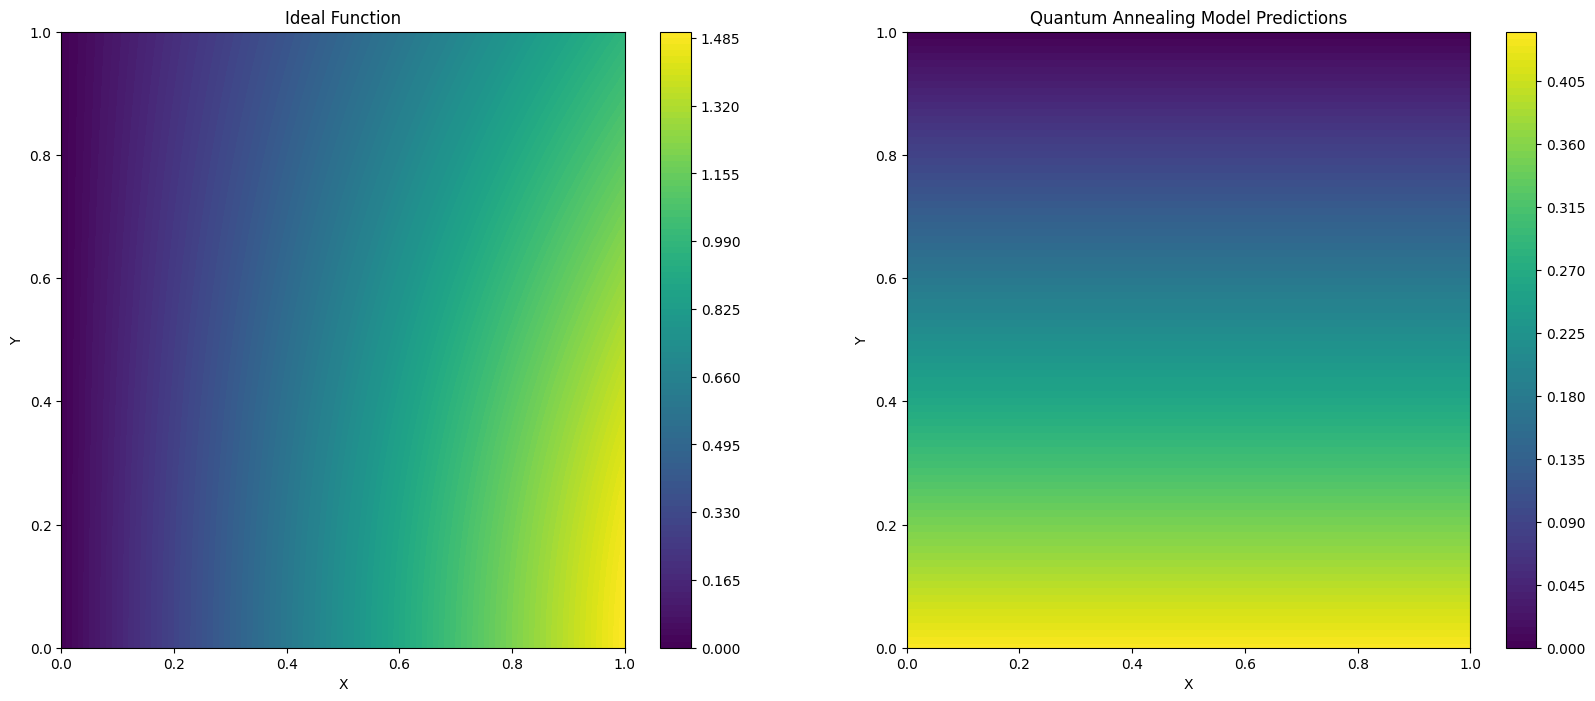

In [9]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.70e-01 | test loss: nan | reg: 5.03e+00 : 100%|███████| 72/72 [01:12<00:00,  1.01s/it]


Training time in seconds of lr=0.001: 72.92381393600044
Learning Rate: 0.001, Train MSE: 0.45303143123827416, Train r2: -1.8410517706564447


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.41e-01 | test loss: nan | reg: 3.41e+00 : 100%|███████| 72/72 [01:09<00:00,  1.03it/s]


Training time in seconds of lr=0.01: 69.93609268100045
Learning Rate: 0.01, Train MSE: 0.016037961419138713, Train r2: 0.8994226988555264


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.20e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:12<00:00,  1.01s/it]


Training time in seconds of lr=0.05: 72.40873776999979
Learning Rate: 0.05, Train MSE: 0.0029604924090455525, Train r2: 0.9814341530834975


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:10<00:00,  1.02it/s]


Training time in seconds of lr=0.1: 70.31649044999904
Learning Rate: 0.1, Train MSE: 0.002930547568470525, Train r2: 0.9816219432377152


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.52e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.2: 71.27493100600077
Learning Rate: 0.2, Train MSE: 0.002849136408418784, Train r2: 0.9821324890949508


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.01e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.5: 71.35216806400058
Learning Rate: 0.5, Train MSE: 0.0028231887881203527, Train r2: 0.9822952118720254
Best Learning Rate: 0.5 with Train MSE: 0.0028231887881203527


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.23e+00 : 100%|███████| 72/72 [01:09<00:00,  1.04it/s]


Training time in seconds: 69.50981463300013
Layer 0 Bezier coefficients:
[[-0.9481836  1.1911924]
 [ 0.9085366 -0.8227947]]
Layer 1 Bezier coefficients:
[[ 1.3811496  -0.08527107]]


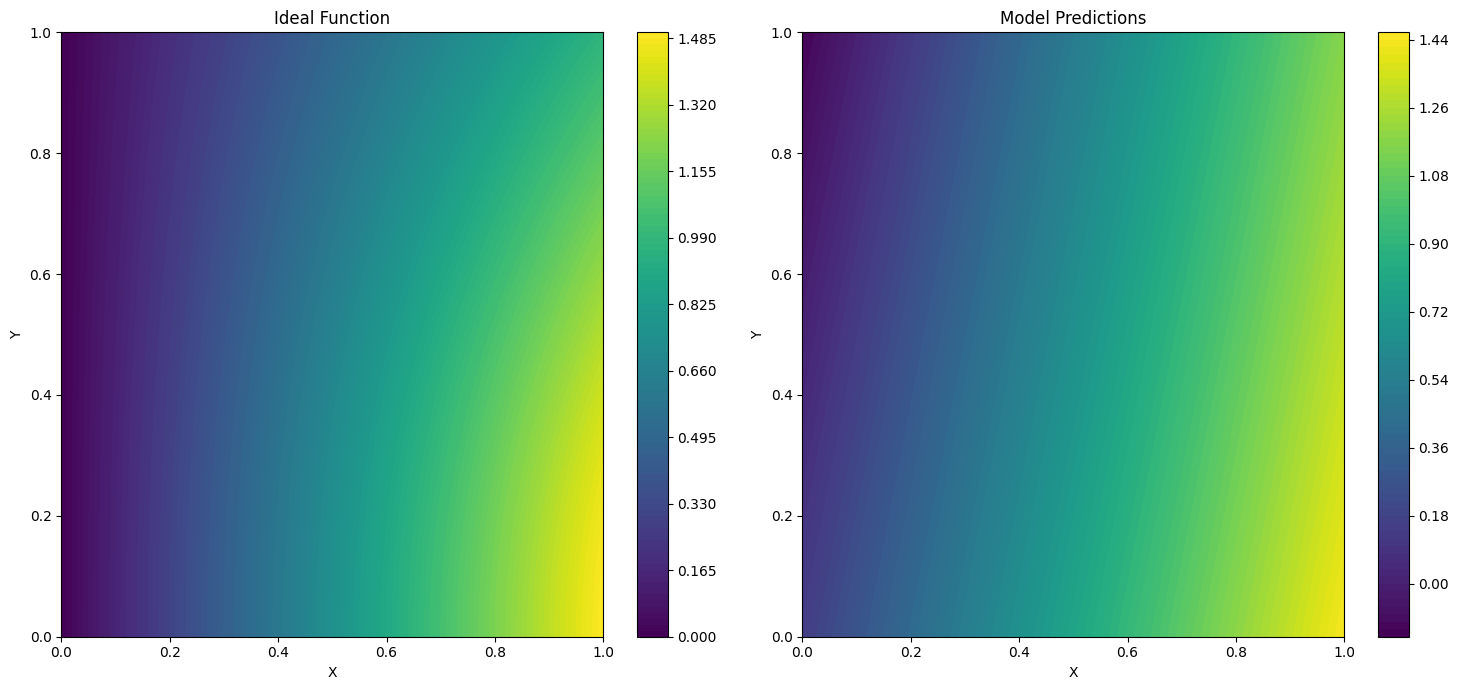

Training time: 69.50981463300013, mse: 0.0028524158077583768, r2: 0.9821119233181459


In [11]:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
adam_steps = 72
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(dataset, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.84e-01 | test loss: nan | reg: 4.43e+00 : 100%|███████| 72/72 [01:08<00:00,  1.05it/s]


Training time in seconds of lr=0.001: 68.57130072200016
Learning Rate: 0.001, Train MSE: 0.47436885392213407, Train r2: -1.9748630656730621


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 3.79e-01 | test loss: nan | reg: 1.16e+01 : 100%|███████| 72/72 [01:09<00:00,  1.03it/s]


Training time in seconds of lr=0.01: 69.62057606000053
Learning Rate: 0.01, Train MSE: 0.1511977526682197, Train r2: 0.05180830000426351


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.80e-01 | test loss: nan | reg: 2.61e+00 : 100%|███████| 72/72 [01:11<00:00,  1.00it/s]


Training time in seconds of lr=0.05: 71.90960377599913
Learning Rate: 0.05, Train MSE: 0.030831825555768053, Train r2: 0.8066473834975161


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:09<00:00,  1.03it/s]


Training time in seconds of lr=0.1: 69.79652506599996
Learning Rate: 0.1, Train MSE: 0.0028532687646244084, Train r2: 0.9821065742530536


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.2: 71.20809082499909
Learning Rate: 0.2, Train MSE: 0.0027938649645554694, Train r2: 0.9824791075029173


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 6.50e-02 | test loss: nan | reg: 2.35e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.5: 71.40830393100077
Learning Rate: 0.5, Train MSE: 0.004236037997739112, Train r2: 0.9734349486057736
Best Learning Rate: 0.2 with Train MSE: 0.0027938649645554694


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:08<00:00,  1.05it/s]


Training time in seconds: 68.36484769399976
Layer 0 Bezier coefficients:
[[ 0.55288744 -0.44502264]
 [-0.07857186  0.17872915]]
Layer 1 Bezier coefficients:
[[ 0.6544534  -0.24935818]]


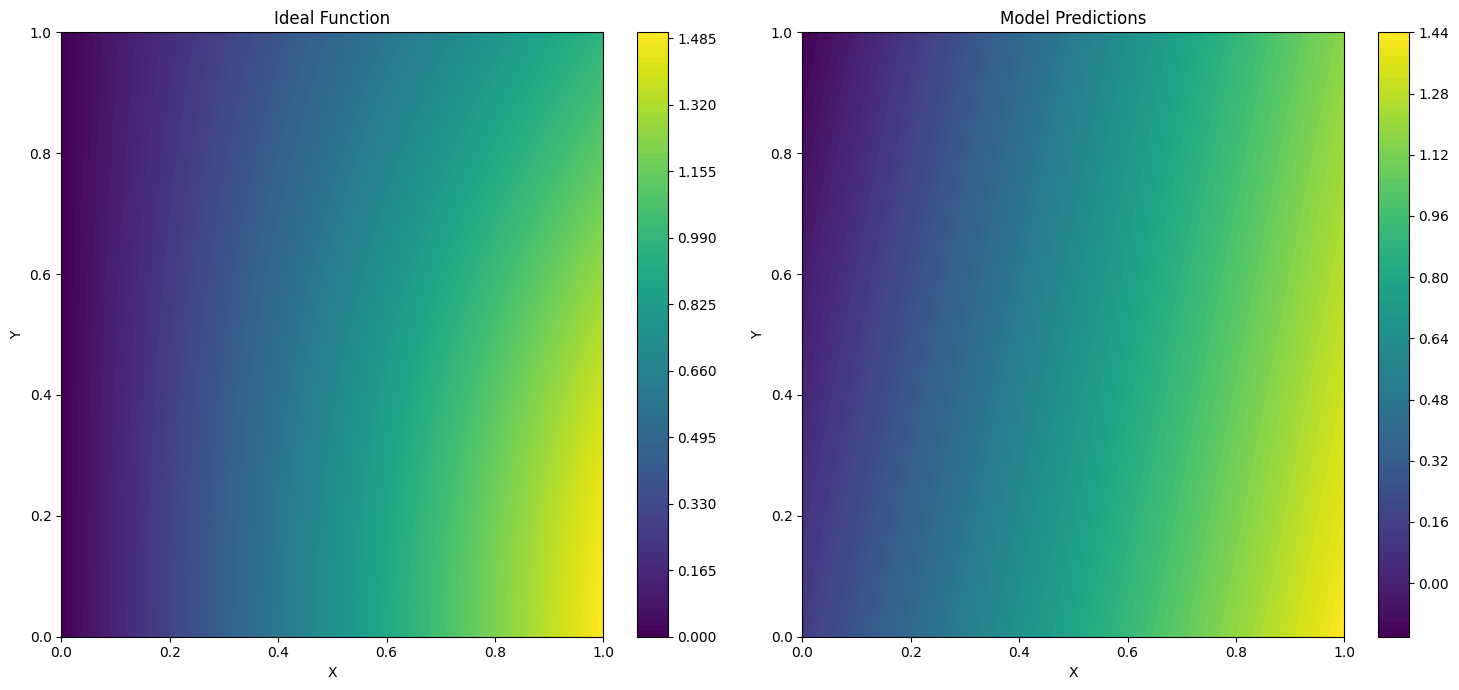

Training time: 68.36484769399976, mse: 0.0027938647160375258, r2: 0.9824791090614236


In [12]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(dataset, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 7.41e-01 | test loss: nan | reg: 2.50e+00 : 100%|███████| 72/72 [01:09<00:00,  1.03it/s]


Training time in seconds of lr=0.001: 69.97876264399929
Learning Rate: 0.001, Train MSE: 0.5570284075184235, Train r2: -2.4932378514236215


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.79e-01 | test loss: nan | reg: 1.44e+01 : 100%|███████| 72/72 [01:08<00:00,  1.05it/s]


Training time in seconds of lr=0.01: 68.51446155200028
Learning Rate: 0.01, Train MSE: 0.23364633298081983, Train r2: -0.46524342959641984


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.14e-02 | test loss: nan | reg: 2.39e+00 : 100%|███████| 72/72 [01:12<00:00,  1.00s/it]


Training time in seconds of lr=0.05: 72.16330356800063
Learning Rate: 0.05, Train MSE: 0.0029078331531901163, Train r2: 0.9817643899319224


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.23e+00 : 100%|███████| 72/72 [01:09<00:00,  1.03it/s]


Training time in seconds of lr=0.1: 69.87424310700044
Learning Rate: 0.1, Train MSE: 0.0027940134146721934, Train r2: 0.9824781765421983


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.18e+00 : 100%|███████| 72/72 [01:09<00:00,  1.03it/s]


Training time in seconds of lr=0.2: 69.95509230800053
Learning Rate: 0.2, Train MSE: 0.0027987262844599383, Train r2: 0.9824486211821678


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.87e-02 | test loss: nan | reg: 2.16e+00 : 100%|███████| 72/72 [01:10<00:00,  1.03it/s]


Training time in seconds of lr=0.5: 70.14761645600083
Learning Rate: 0.5, Train MSE: 0.0036370139314339037, Train r2: 0.9771915497307564
Best Learning Rate: 0.1 with Train MSE: 0.0027940134146721934


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.23e+00 : 100%|███████| 72/72 [01:12<00:00,  1.01s/it]


Training time in seconds: 72.94437416599976
Layer 0 Bezier coefficients:
[[ 0.4067619  -0.642441  ]
 [-0.247131    0.13470277]]
Layer 1 Bezier coefficients:
[[ 0.3316182 -0.1876788]]


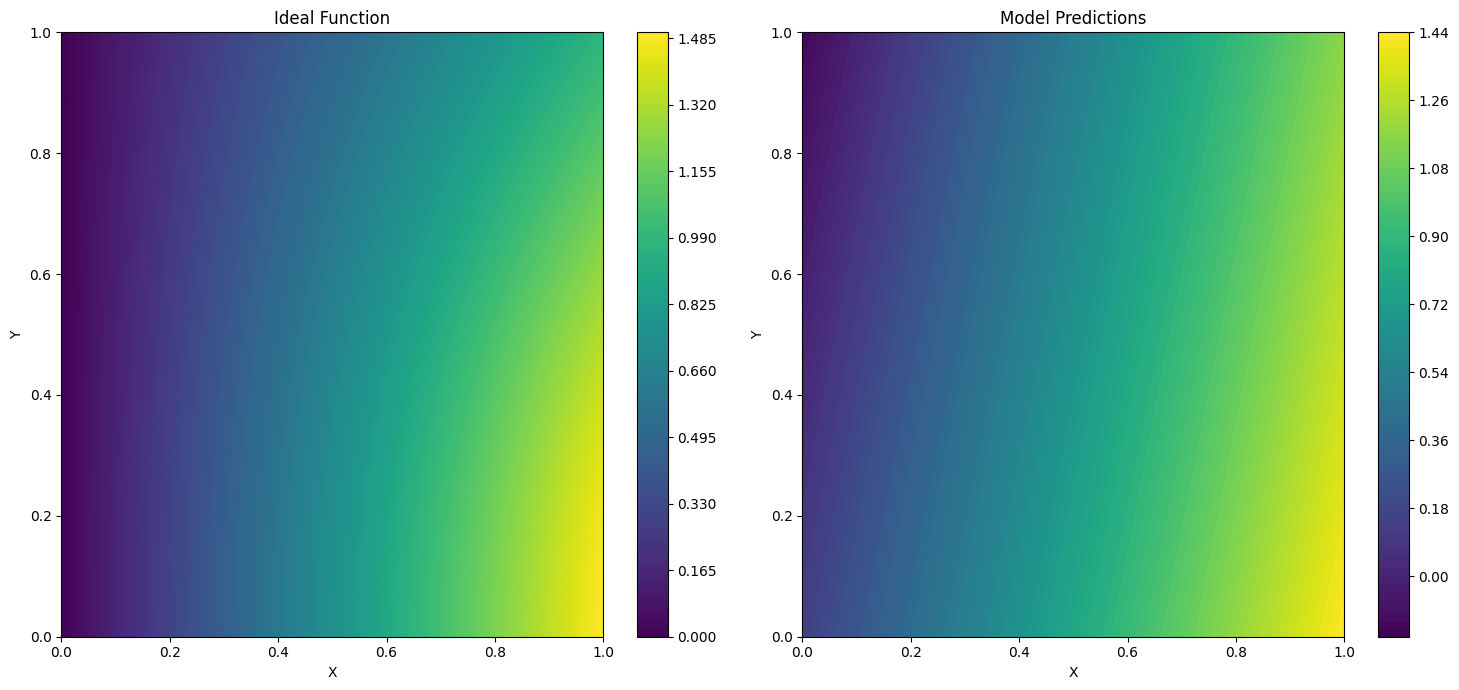

Training time: 72.94437416599976, mse: 0.002794012807602185, r2: 0.982478180349257


In [13]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(dataset, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [14]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

Quantum Annealing Metrics:
Total run time in seconds: 16.01232805600037
MSE: 0.0031, r2: 0.9803
Simulated Annealing Metrics
Total run time in seconds: 26.13870004599994
MSE: 0.0031, r2: 0.9803
Adam Optimizer Metrics
Total run time in seconds: 69.50981463300013
MSE: 0.0029, r2: 0.9821
SGD Optimizer Metrics
Total run time in seconds: 68.36484769399976
MSE: 0.0028, r2: 0.9825
AdaGrad Optimizer Metrics
Total run time in seconds: 72.94437416599976
MSE: 0.0028, r2: 0.9825


# Now lets add a few more datapoints to make dataset 2

In [10]:
dataset_1 = dataset
X_1 = X
y_1 = 1
x_data_1 = x_data
y_data_1 = y_data
z_data_1 = z_data

In [11]:
dataset = dataset_split1
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [12]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file2, load_filename=save_file1
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

Time taken for elapsed_precompute_powers: 0.0140584 seconds
Invalid term: AUX43*P1_0_plus_0
Invalid term: AUX9
Invalid term: AUX2*P3_0_plus_2
Invalid term: AUX14*P1_0_plus_0
Invalid term: AUX8*AUX22
Invalid term: AUX2*AUX14
Invalid term: AUX26*AUX14
Invalid term: P2_0_plus_2*P3_1_plus_2
Invalid term: AUX26*P3_0_plus_2
Invalid term: AUX2*P3_1_plus_2
Invalid term: AUX9*AUX2
Invalid term: AUX14*P2_0_plus_2
Invalid term: P1_0_plus_0*P3_1_plus_2
Invalid term: AUX26*P3_1_plus_2
Invalid term: P3_0_plus_2
Invalid term: AUX9*AUX26


Invalid coefficient: AUX43
Invalid coefficient: AUX9
Invalid coefficient: AUX2
Invalid coefficient: AUX14
Invalid coefficient: AUX8
Invalid coefficient: AUX2
Invalid coefficient: AUX26
Invalid coefficient: P2_0_plus_2
Invalid coefficient: AUX26
Invalid coefficient: AUX2
Invalid coefficient: AUX9
Invalid coefficient: AUX14
Invalid coefficient: P1_0_plus_0
Invalid coefficient: AUX26
Invalid coefficient: P3_0_plus_2
Invalid coefficient: AUX9


In [13]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.5018781809994834


In [19]:
# Combine datasets
combined_train_input = torch.cat((dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_2 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_access_time: 180295 microseconds
charge_time: 2989975 microseconds
run_time: 2989975 microseconds
problem_id: 0467184c-bf0c-4eb8-8d5e-ae37a4d788d4 microseconds

QPU Access Time: 180295 microseconds

Total D-Wave Run Time Including Setup: 2989975 microseconds
Time spent on hybrid part 2: 2.989975
Time spent on part 3: 0.0004606769998645177
Time spent on optimization: 3.464285203999266
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.0, 0.25]
optimized_coefficients_3: [1.5, 0.25]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX3

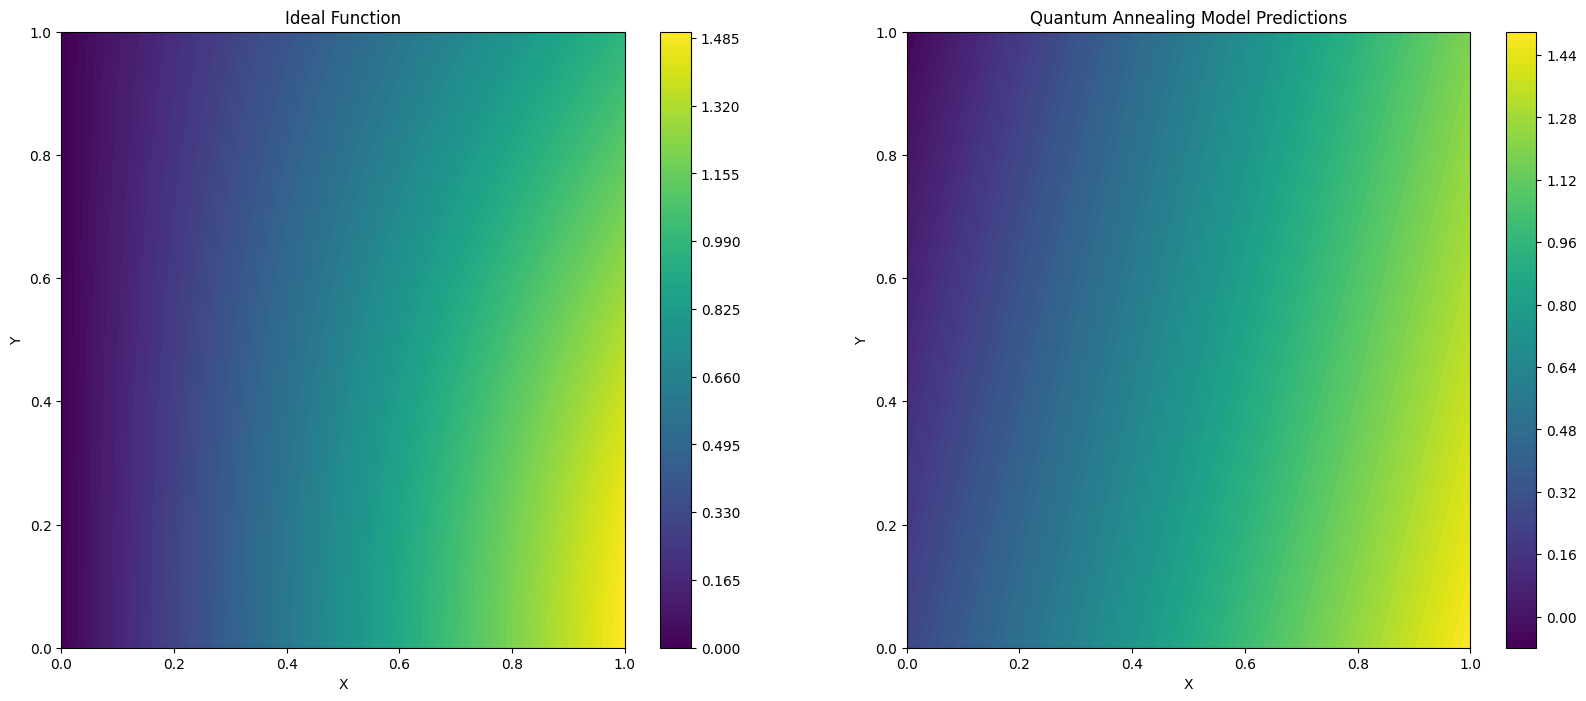

In [20]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 13.55134513000121
Time spent on part 3: 0.0014493809994746698
Time spent on optimization: 14.026644038000086
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.0, 0.0]
optimized_coefficients_3: [1.5, 0.0]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: Cor

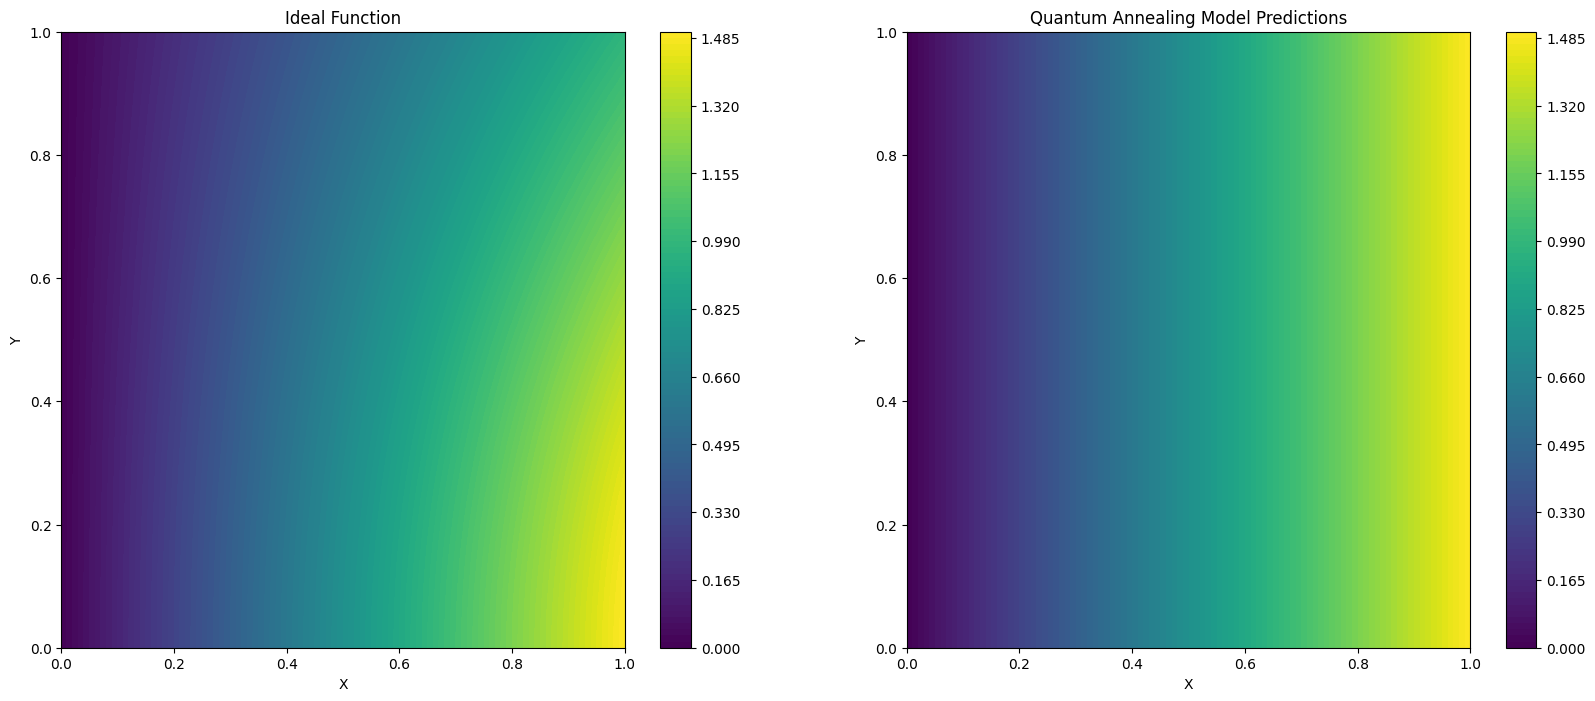

In [21]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.20e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:17<00:00,  1.07s/it]


Training time in seconds of lr=0.05: 77.13832127299975
Learning Rate: 0.05, Train MSE: 0.0029632001765284477, Train r2: 0.9814171721257287


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:17<00:00,  1.08s/it]


Training time in seconds of lr=0.1: 77.70827872100017
Learning Rate: 0.1, Train MSE: 0.0029403341629684744, Train r2: 0.9815605695234211


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.07e-02 | test loss: nan | reg: 2.52e+00 : 100%|███████| 72/72 [01:15<00:00,  1.05s/it]


Training time in seconds of lr=0.2: 75.40472365099959
Learning Rate: 0.2, Train MSE: 0.0028510106872263108, Train r2: 0.9821207351133114
Best Learning Rate: 0.2 with Train MSE: 0.0028510106872263108


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.52e+00 : 100%|███████| 72/72 [01:16<00:00,  1.07s/it]


Training time in seconds: 76.82246470799873
Layer 0 Bezier coefficients:
[[ 1.4238938 -2.023966 ]
 [-0.7763675  0.9442215]]
Layer 1 Bezier coefficients:
[[0.75370914 0.22889446]]


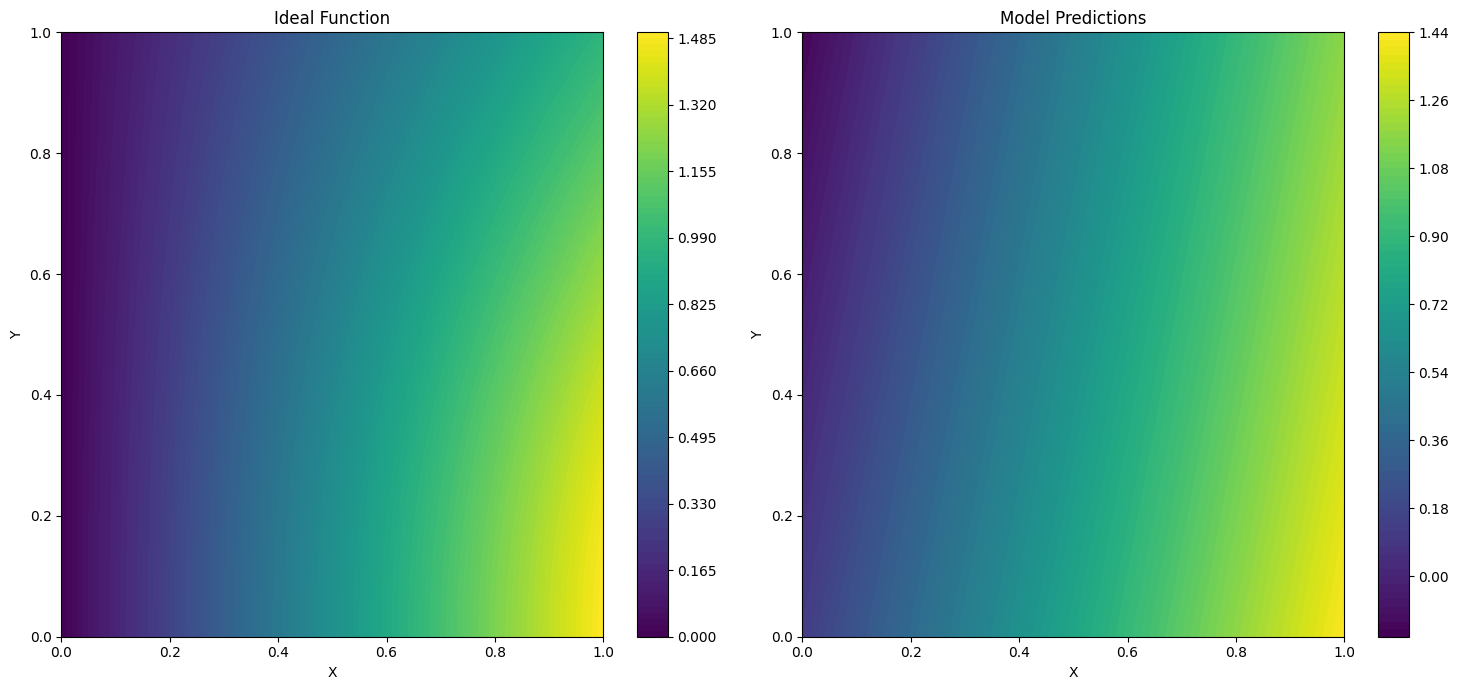

Training time: 76.82246470799873, mse: 0.0028472537822399465, r2: 0.9821442954246445


In [22]:
# Change the learning rates to be in a narrower range where we saw optimal lrs in round 1.
learning_rates = [0.05, 0.1, 0.2]
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_2, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.80e-01 | test loss: nan | reg: 2.61e+00 : 100%|███████| 72/72 [01:27<00:00,  1.21s/it]


Training time in seconds of lr=0.05: 87.24294725399886
Learning Rate: 0.05, Train MSE: 0.030949324992777305, Train r2: 0.8059105207534591


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:15<00:00,  1.05s/it]


Training time in seconds of lr=0.1: 75.83369111899992
Learning Rate: 0.1, Train MSE: 0.0028535332302034844, Train r2: 0.9821049157358959


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:14<00:00,  1.04s/it]


Training time in seconds of lr=0.2: 74.60431292100111
Learning Rate: 0.2, Train MSE: 0.0027938397191188996, Train r2: 0.9824792658221582
Best Learning Rate: 0.2 with Train MSE: 0.0027938397191188996


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:18<00:00,  1.09s/it]


Training time in seconds: 78.75357387000076
Layer 0 Bezier coefficients:
[[ 0.5522646  -0.4458594 ]
 [-0.07909913  0.17824514]]
Layer 1 Bezier coefficients:
[[ 0.65275466 -0.25032005]]


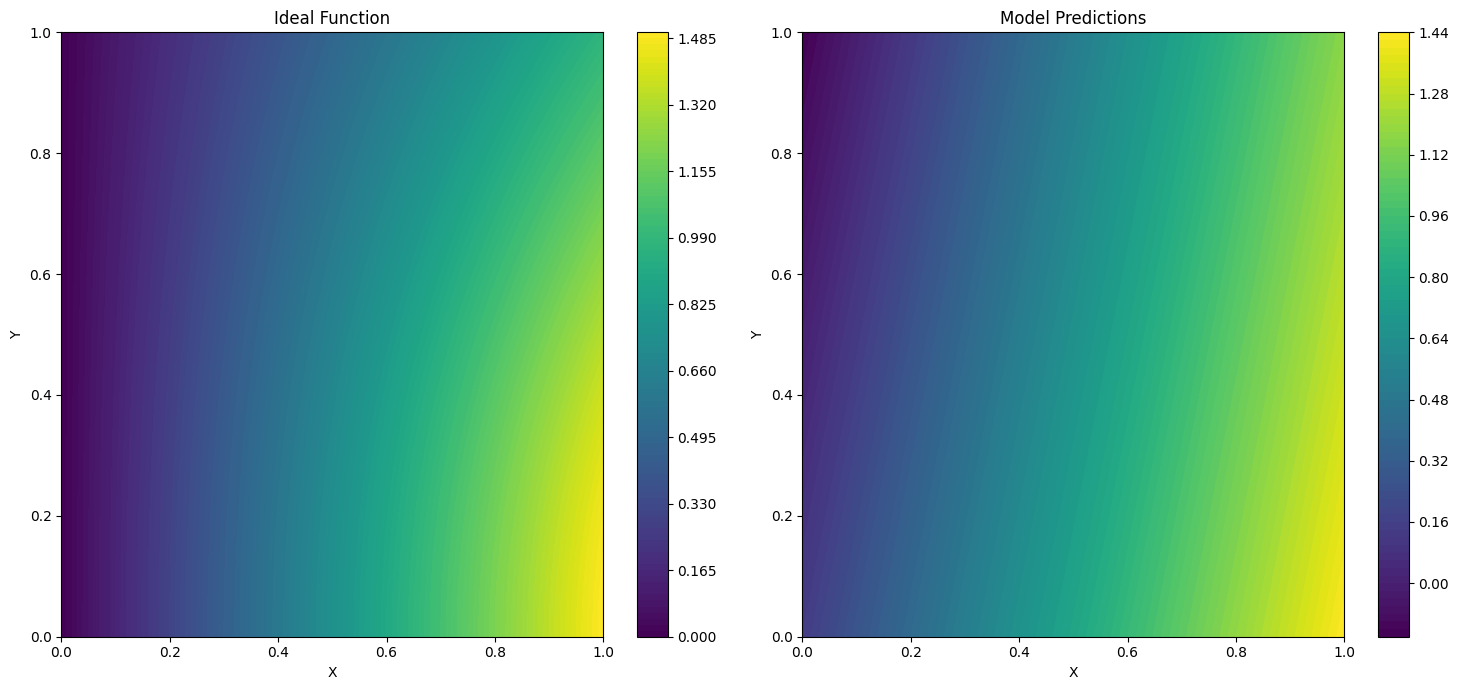

Training time: 78.75357387000076, mse: 0.0027938398211149185, r2: 0.9824792651825205


In [23]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_2, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.14e-02 | test loss: nan | reg: 2.40e+00 : 100%|███████| 72/72 [01:24<00:00,  1.17s/it]


Training time in seconds of lr=0.05: 84.53851349300021
Learning Rate: 0.05, Train MSE: 0.0029065839241775686, Train r2: 0.9817722240998262


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:11<00:00,  1.01it/s]


Training time in seconds of lr=0.1: 71.32630674900065
Learning Rate: 0.1, Train MSE: 0.0027939858325890703, Train r2: 0.9824783495150224


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.18e+00 : 100%|███████| 72/72 [01:23<00:00,  1.16s/it]


Training time in seconds of lr=0.2: 83.39668188599899
Learning Rate: 0.2, Train MSE: 0.002797444486328853, Train r2: 0.982456659597604
Best Learning Rate: 0.1 with Train MSE: 0.0027939858325890703


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:25<00:00,  1.19s/it]


Training time in seconds: 85.85698445399976
Layer 0 Bezier coefficients:
[[ 0.42874616 -0.6449935 ]
 [-0.23655024  0.15771928]]
Layer 1 Bezier coefficients:
[[ 0.3510951  -0.14852004]]


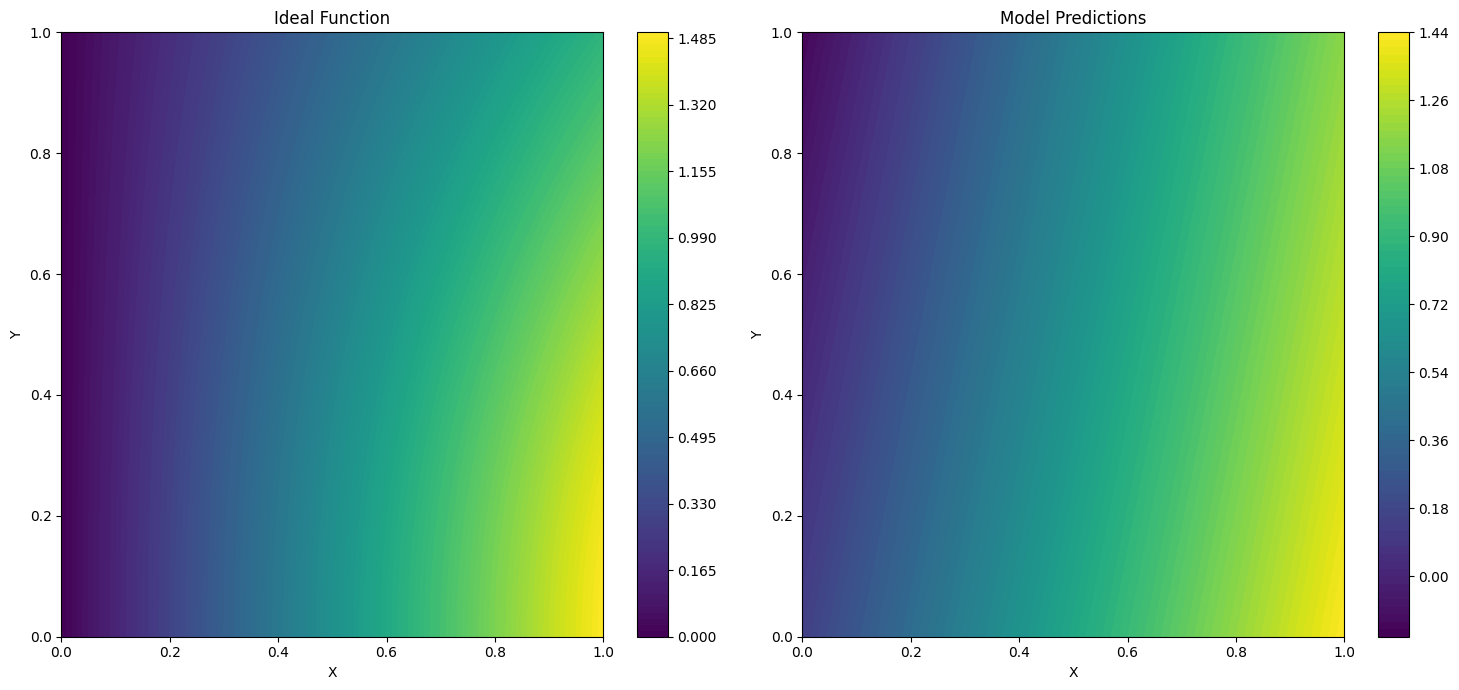

Training time: 85.85698445399976, mse: 0.0027939861161885974, r2: 0.9824783477365124


In [24]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_2, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [25]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 3.464285203999266
MSE: 0.0081, r2: 0.9495
Simulated Annealing Metrics
Total run time in seconds: 14.026644038000086
MSE: 0.0238, r2: 0.8510
Adam Optimizer Metrics
Total run time in seconds: 76.82246470799873
MSE: 0.0028, r2: 0.9821
SGD Optimizer Metrics
Total run time in seconds: 78.75357387000076
MSE: 0.0028, r2: 0.9825
AdaGrad Optimizer Metrics
Total run time in seconds: 85.85698445399976
MSE: 0.0028, r2: 0.9825
Array of time for quantum in each training/retraining: [16.01232805600037, 3.464285203999266], total time: 19.476613259999638
Array of time for simulated in each training/retraining: [26.13870004599994, 14.026644038000086], total time: 40.165344084000026
Array of time for adam in each training/retraining: [69.50981463300013, 76.82246470799873], total time: 146.33227934099887
Array of time for SDG in each training/retraining: [68.36484769399976, 78.75357387000076], total time: 147.11842156400053
Array of time for adagrad in

# Adding a few more datapoints to make dataset 3

In [26]:
dataset_2 = dataset
X_2 = X
y_2 = 1
x_data_2 = x_data
y_data_2 = y_data
z_data_2 = z_data

In [27]:
dataset = dataset_split2
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [28]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file3, load_filename=save_file2
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [29]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.4756515480003145


In [30]:
# Combine datasets
combined_train_input = torch.cat((dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_3 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_access_time: 139763 microseconds
charge_time: 2994608 microseconds
run_time: 2994608 microseconds
problem_id: 038c12c4-1902-4ebc-9bba-aadbf5506b6d microseconds

QPU Access Time: 139763 microseconds

Total D-Wave Run Time Including Setup: 2994608 microseconds
Time spent on hybrid part 2: 2.994608
Time spent on part 3: 0.0004761950003739912
Time spent on optimization: 3.4707357430006884
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX

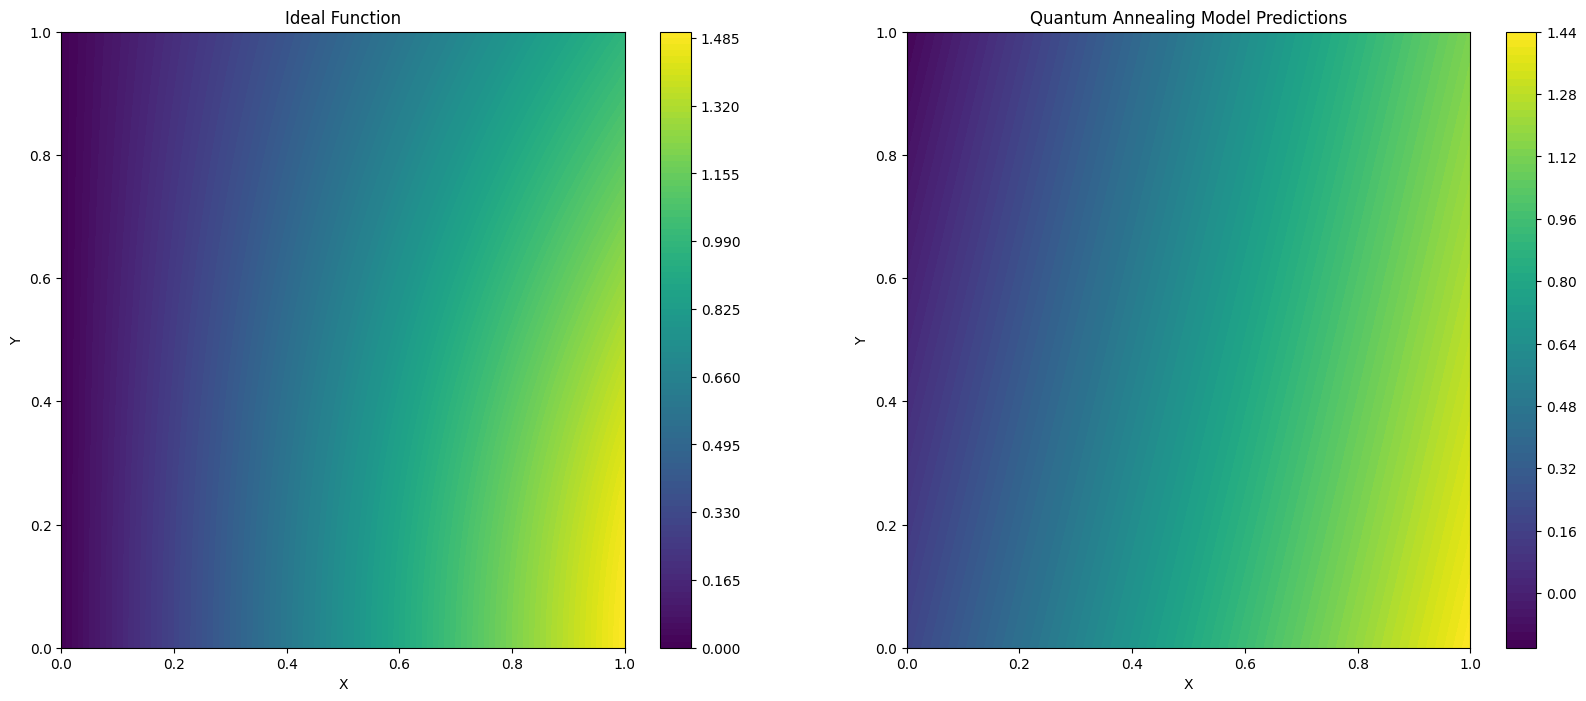

In [31]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 19.377631694998854
Time spent on part 3: 0.0014596890014217934
Time spent on optimization: 19.85474293200059
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: C

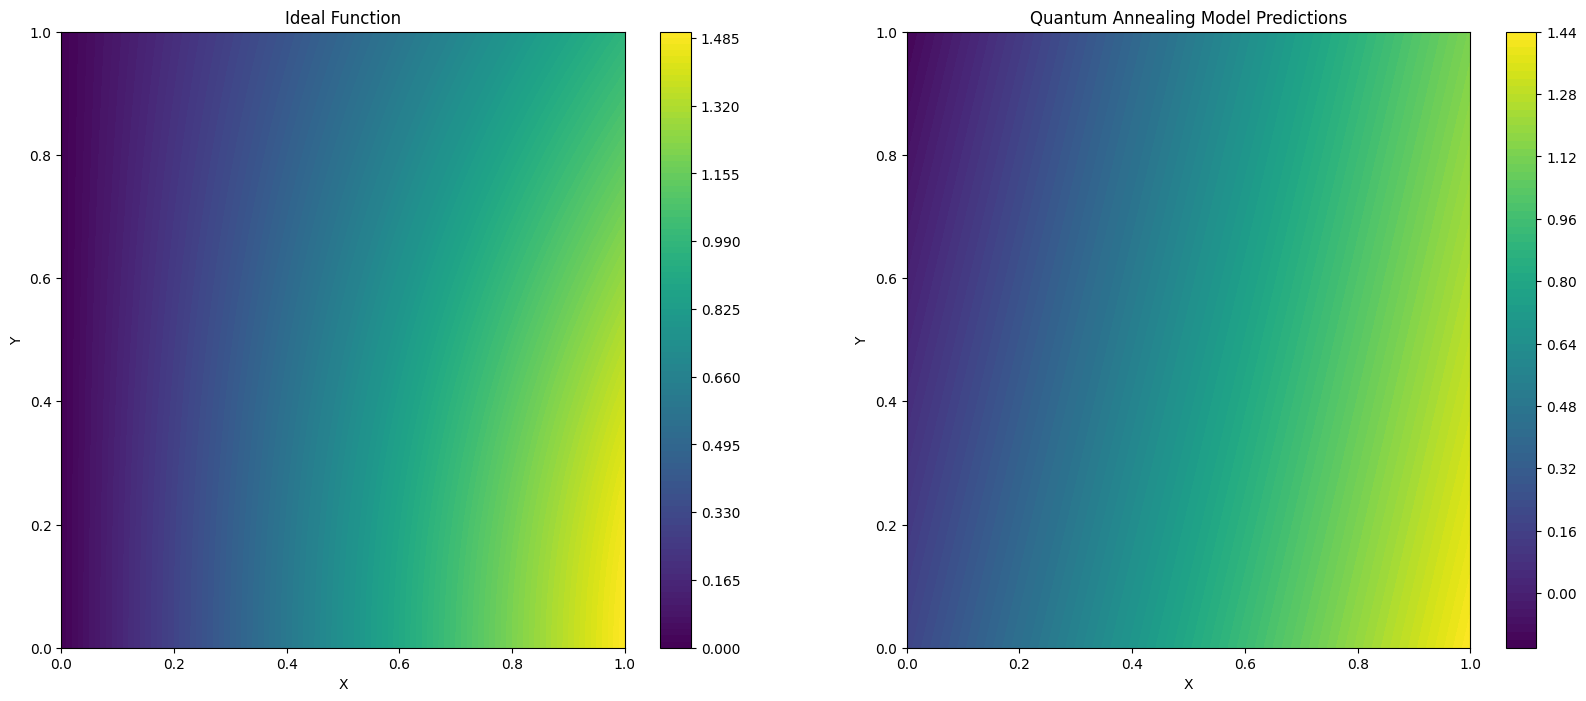

In [32]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.20e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:28<00:00,  1.23s/it]


Training time in seconds of lr=0.05: 88.21919819899995
Learning Rate: 0.05, Train MSE: 0.00296026774985584, Train r2: 0.9814355619667332


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:34<00:00,  1.31s/it]


Training time in seconds of lr=0.1: 94.61850513100035
Learning Rate: 0.1, Train MSE: 0.002931623430792617, Train r2: 0.9816151962874058


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.51e+00 : 100%|███████| 72/72 [01:29<00:00,  1.24s/it]


Training time in seconds of lr=0.2: 89.19107705900024
Learning Rate: 0.2, Train MSE: 0.0028368187425436876, Train r2: 0.9822097356699823
Best Learning Rate: 0.2 with Train MSE: 0.0028368187425436876


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.07e-02 | test loss: nan | reg: 2.52e+00 : 100%|███████| 72/72 [01:35<00:00,  1.33s/it]


Training time in seconds: 95.413181979
Layer 0 Bezier coefficients:
[[ 1.4265064  -2.0155323 ]
 [-0.77236205  0.9489852 ]]
Layer 1 Bezier coefficients:
[[0.75943595 0.23445362]]


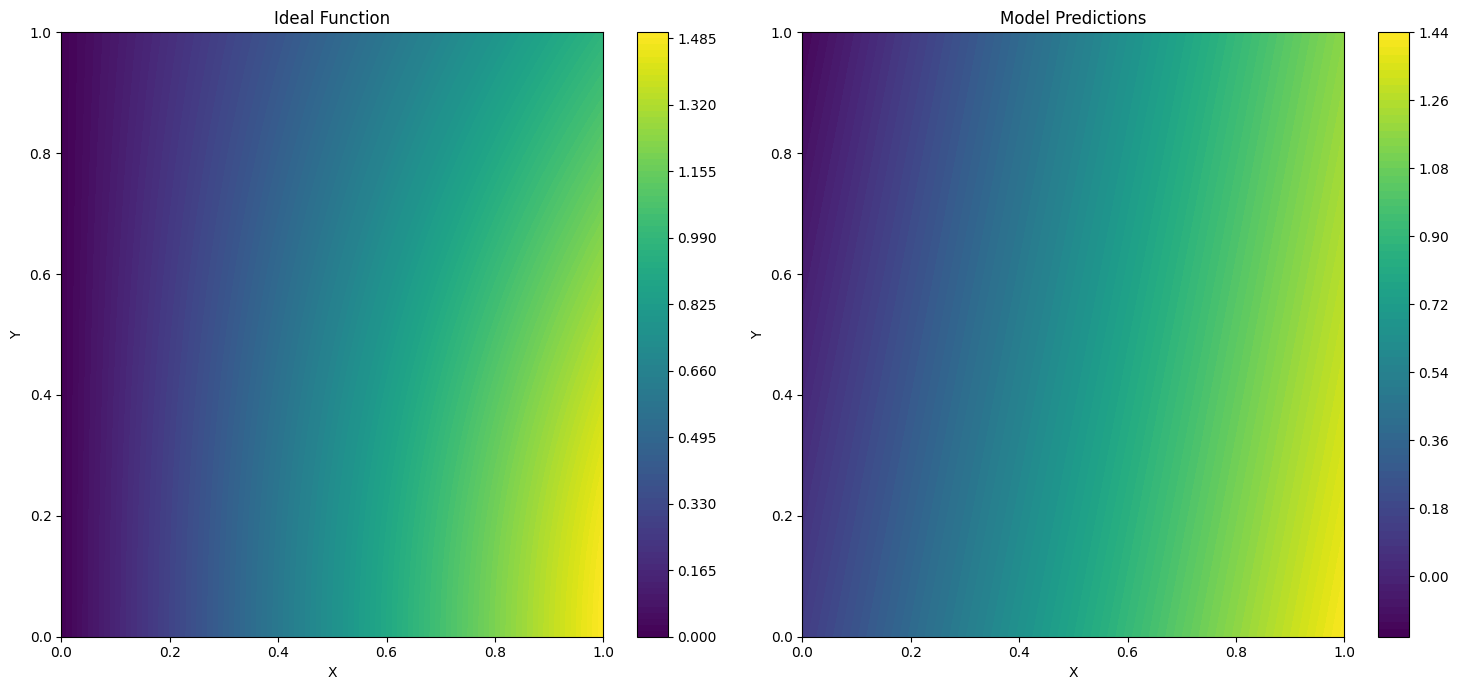

Training time: 95.413181979, mse: 0.0028414098819113764, r2: 0.9821809437060467


In [33]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_3, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.80e-01 | test loss: nan | reg: 2.61e+00 : 100%|███████| 72/72 [01:24<00:00,  1.18s/it]


Training time in seconds of lr=0.05: 84.74828077799975
Learning Rate: 0.05, Train MSE: 0.030916616508421438, Train r2: 0.8061156422770159


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.05e-02 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:28<00:00,  1.22s/it]


Training time in seconds of lr=0.1: 88.04840549599976
Learning Rate: 0.1, Train MSE: 0.002853445695122938, Train r2: 0.9821054646860976


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:24<00:00,  1.18s/it]


Training time in seconds of lr=0.2: 84.87162438700034
Learning Rate: 0.2, Train MSE: 0.0027938531746627723, Train r2: 0.9824791814397199
Best Learning Rate: 0.2 with Train MSE: 0.0027938531746627723


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:18<00:00,  1.08s/it]


Training time in seconds: 78.04430666100052
Layer 0 Bezier coefficients:
[[ 0.5525569  -0.445407  ]
 [-0.07873074  0.17854269]]
Layer 1 Bezier coefficients:
[[ 0.6537366  -0.24983406]]


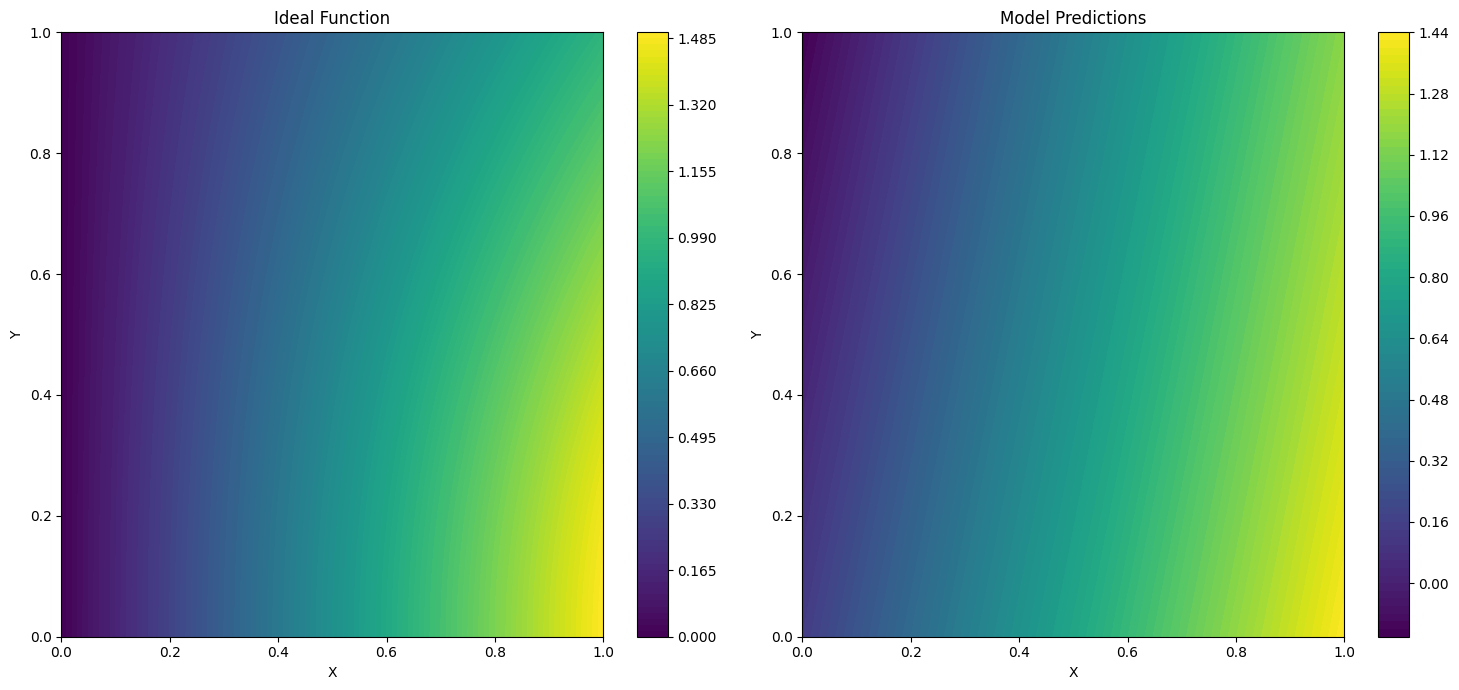

Training time: 78.04430666100052, mse: 0.0027938530160901516, r2: 0.9824791824341609


In [34]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_3, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.14e-02 | test loss: nan | reg: 2.39e+00 : 100%|███████| 72/72 [01:21<00:00,  1.13s/it]


Training time in seconds of lr=0.05: 81.62845280399961
Learning Rate: 0.05, Train MSE: 0.002904975364355902, Train r2: 0.9817823117039403


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:18<00:00,  1.09s/it]


Training time in seconds of lr=0.1: 78.62716518599882
Learning Rate: 0.1, Train MSE: 0.002793994673575591, Train r2: 0.9824782940714071


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:28<00:00,  1.22s/it]


Training time in seconds of lr=0.2: 88.01394071899995
Learning Rate: 0.2, Train MSE: 0.0027940537250974637, Train r2: 0.9824779237473651
Best Learning Rate: 0.1 with Train MSE: 0.002793994673575591


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:15<00:00,  1.05s/it]


Training time in seconds: 75.92565579100119
Layer 0 Bezier coefficients:
[[ 0.4288086  -0.6454093 ]
 [-0.23581533  0.15852086]]
Layer 1 Bezier coefficients:
[[ 0.35159826 -0.14819886]]


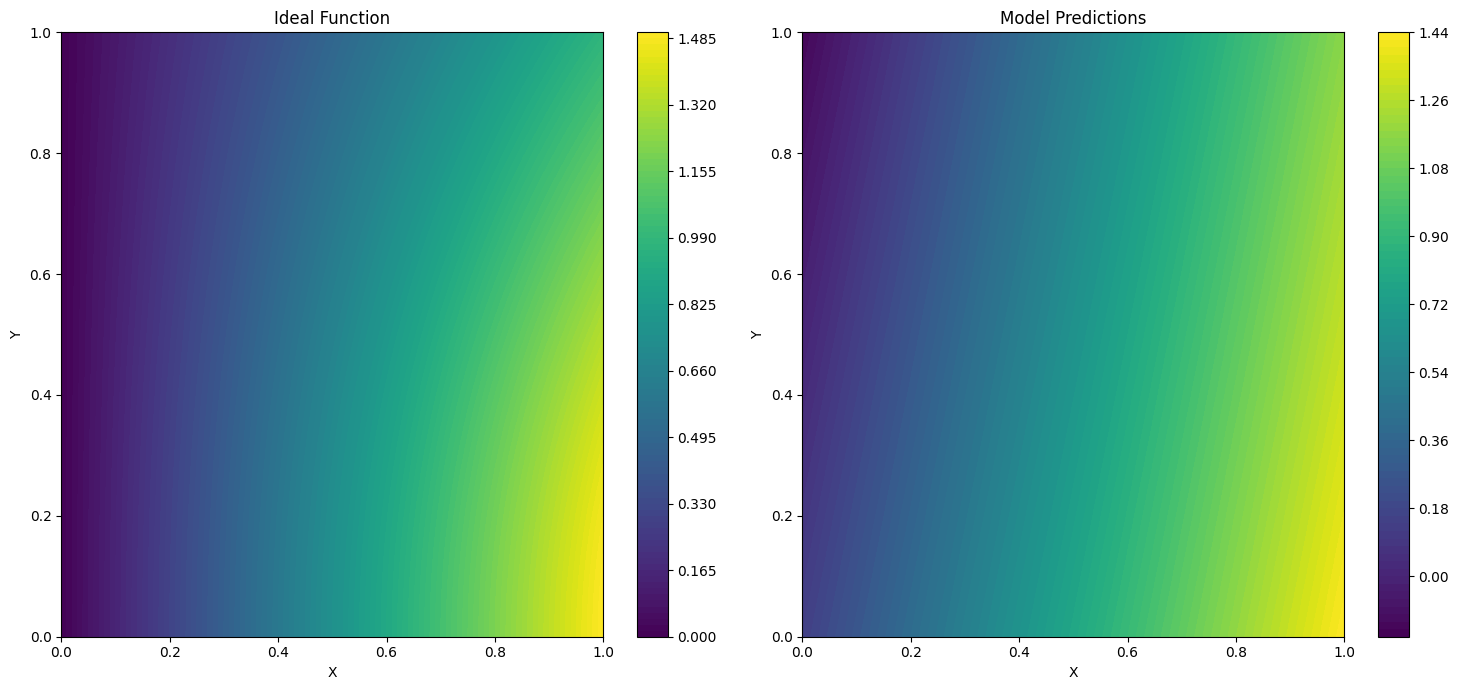

Training time: 75.92565579100119, mse: 0.0027939944711896925, r2: 0.98247829534061


In [35]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_3, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [36]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 3.4707357430006884
MSE: 0.0031, r2: 0.9803
Simulated Annealing Metrics
Total run time in seconds: 19.85474293200059
MSE: 0.0031, r2: 0.9803
Adam Optimizer Metrics
Total run time in seconds: 95.413181979
MSE: 0.0028, r2: 0.9822
SGD Optimizer Metrics
Total run time in seconds: 78.04430666100052
MSE: 0.0028, r2: 0.9825
AdaGrad Optimizer Metrics
Total run time in seconds: 75.92565579100119
MSE: 0.0028, r2: 0.9825
Array of time for quantum in each training/retraining: [16.01232805600037, 3.464285203999266, 3.4707357430006884], total time: 22.947349003000326
Array of time for simulated in each training/retraining: [26.13870004599994, 14.026644038000086, 19.85474293200059], total time: 60.020087016000616
Array of time for adam in each training/retraining: [69.50981463300013, 76.82246470799873, 95.413181979], total time: 241.74546131999887
Array of time for SDG in each training/retraining: [68.36484769399976, 78.75357387000076, 78.044306661

# Adding a few more datapoints for dataset 4

In [37]:
dataset_3 = dataset
X_3 = X
y_3 = 1
x_data_3 = x_data
y_data_3 = y_data
z_data_3 = z_data

In [38]:
dataset = dataset_split3
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [39]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    save_filename=save_file4, load_filename=save_file3
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [40]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.47322678300042753


In [41]:
# Combine datasets
combined_train_input = torch.cat((dataset_3['train_input'], dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_3['train_label'], dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_3['test_input'], dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_3['test_label'], dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_4 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_access_time: 149887 microseconds
charge_time: 2993069 microseconds
run_time: 2993069 microseconds
problem_id: 265c1dbc-a928-4150-b7e1-787408908355 microseconds

QPU Access Time: 149887 microseconds

Total D-Wave Run Time Including Setup: 2993069 microseconds
Time spent on hybrid part 2: 2.9930689999999998
Time spent on part 3: 0.0004791189985553501
Time spent on optimization: 3.4667749019989826
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.0, 0.25]
optimized_coefficients_3: [1.5, 0.25]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: C

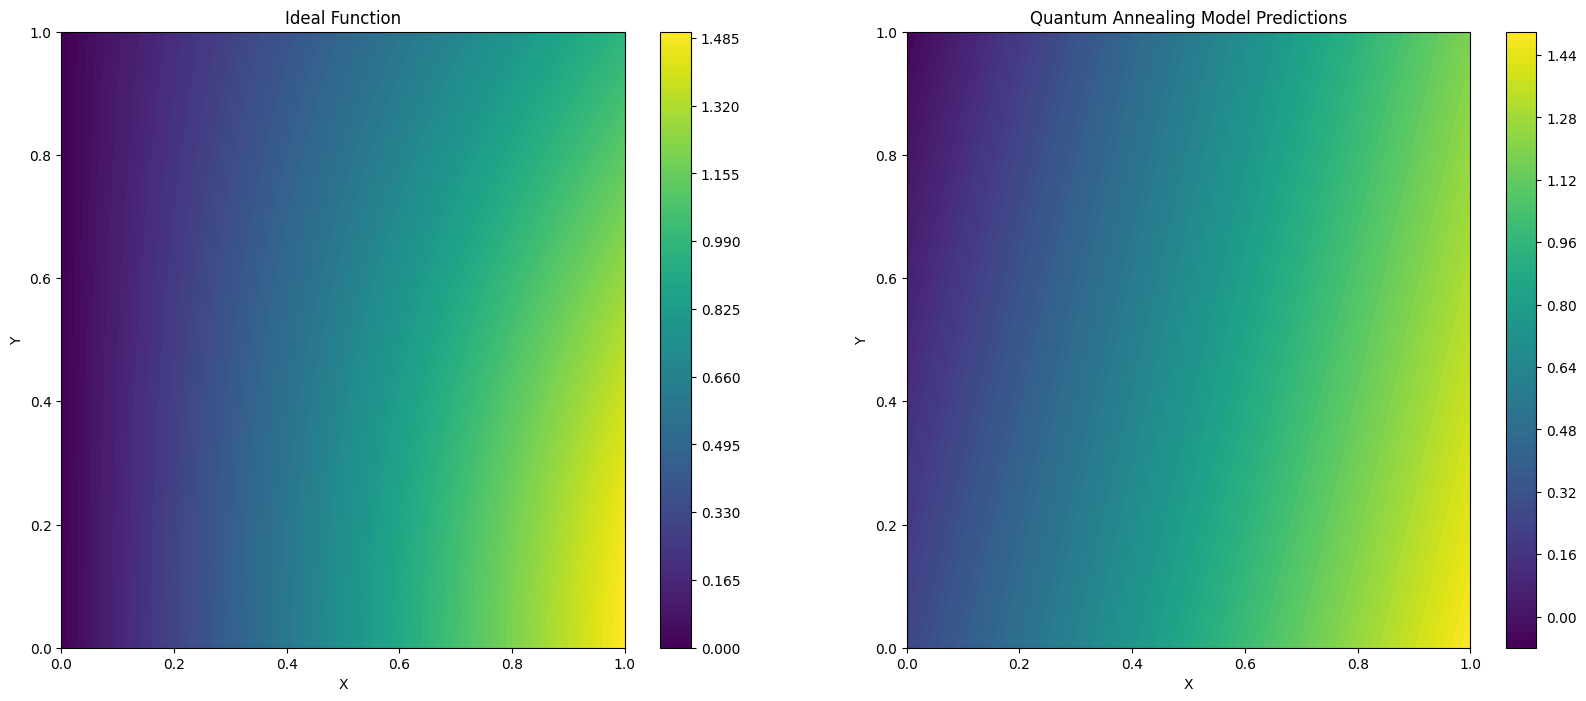

In [42]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 13.152124202000778
Time spent on part 3: 0.0014207679996616207
Time spent on optimization: 13.626771753000867
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: 

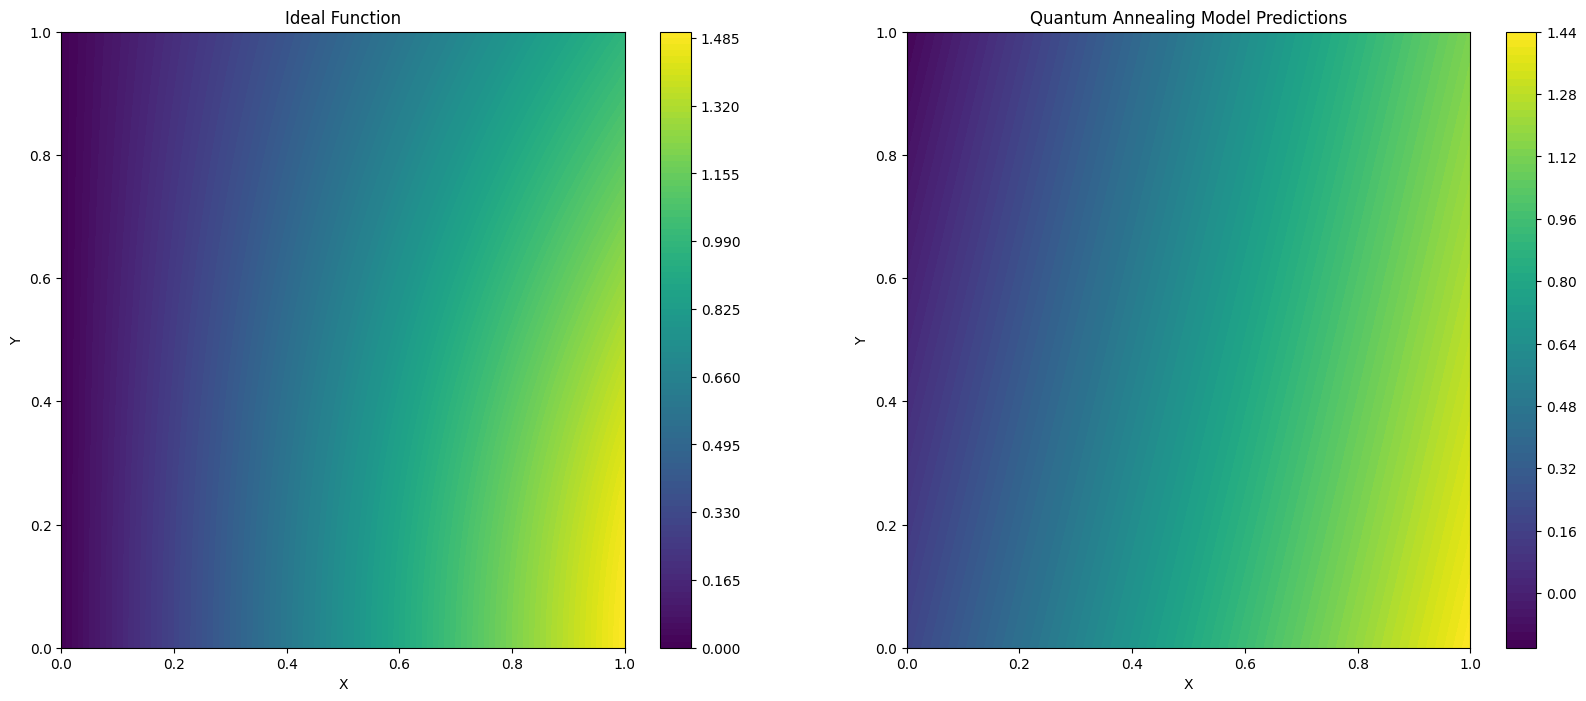

In [43]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.22e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:31<00:00,  1.27s/it]


Training time in seconds of lr=0.05: 91.49114861700036
Learning Rate: 0.05, Train MSE: 0.0030188058890023325, Train r2: 0.9810684574516702


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.04e-02 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:34<00:00,  1.31s/it]


Training time in seconds of lr=0.1: 94.65185847199973
Learning Rate: 0.1, Train MSE: 0.002933163503039652, Train r2: 0.9816055381827299


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.06e-02 | test loss: nan | reg: 2.51e+00 : 100%|███████| 72/72 [01:19<00:00,  1.11s/it]


Training time in seconds of lr=0.2: 79.80888550100099
Learning Rate: 0.2, Train MSE: 0.00284369978690471, Train r2: 0.9821665832484993
Best Learning Rate: 0.2 with Train MSE: 0.00284369978690471


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.08e-02 | test loss: nan | reg: 2.51e+00 : 100%|███████| 72/72 [01:21<00:00,  1.13s/it]


Training time in seconds: 81.13552230800087
Layer 0 Bezier coefficients:
[[ 1.4253459  -2.0084524 ]
 [-0.77373666  0.94812655]]
Layer 1 Bezier coefficients:
[[0.7567489  0.22890575]]


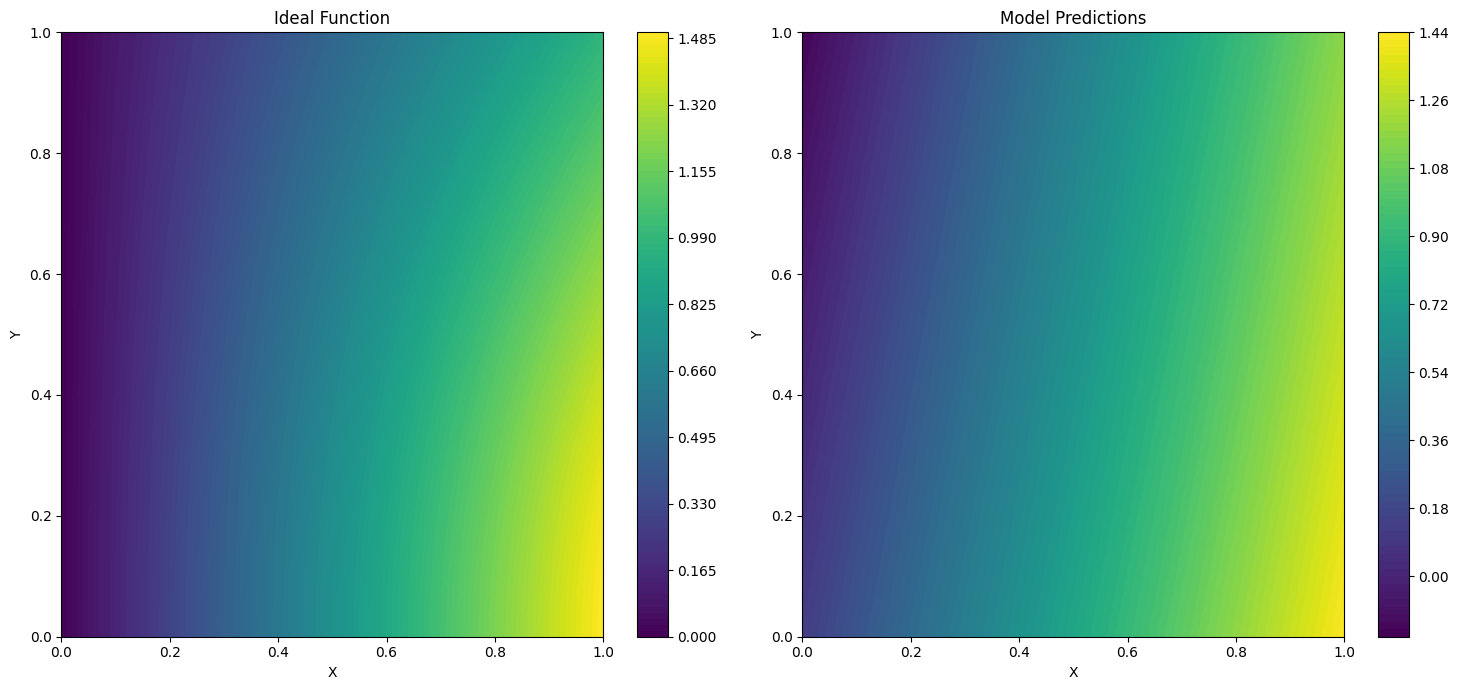

Training time: 81.13552230800087, mse: 0.0028425476604336444, r2: 0.982173808466718


In [44]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_4, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.59e-01 | test loss: nan | reg: 2.61e+00 : 100%|███████| 72/72 [01:28<00:00,  1.23s/it]


Training time in seconds of lr=0.05: 88.81798793000053
Learning Rate: 0.05, Train MSE: 0.023849520077685378, Train r2: 0.8504348339345643


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.08e-02 | test loss: nan | reg: 2.28e+00 : 100%|███████| 72/72 [01:26<00:00,  1.20s/it]


Training time in seconds of lr=0.1: 86.07791178500156
Learning Rate: 0.1, Train MSE: 0.0028756848127274226, Train r2: 0.9819659986797868


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:25<00:00,  1.19s/it]


Training time in seconds of lr=0.2: 85.75530316000004
Learning Rate: 0.2, Train MSE: 0.00279385667399625, Train r2: 0.9824791594946917
Best Learning Rate: 0.2 with Train MSE: 0.00279385667399625


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:26<00:00,  1.21s/it]


Training time in seconds: 86.91400257799978
Layer 0 Bezier coefficients:
[[ 0.55231863 -0.44626445]
 [-0.07934544  0.17812867]]
Layer 1 Bezier coefficients:
[[ 0.6520128  -0.25002006]]


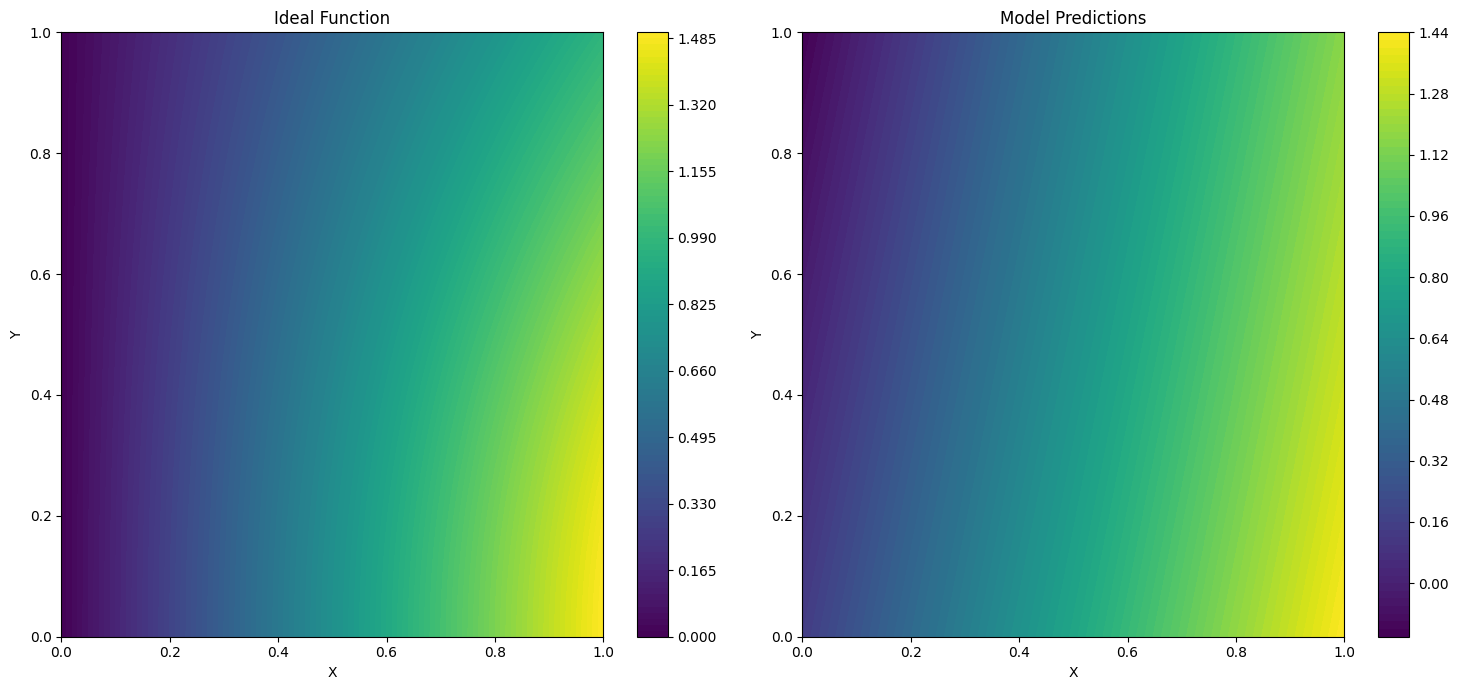

Training time: 86.91400257799978, mse: 0.0027938567861929137, r2: 0.9824791587910837


In [45]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_4, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 5.14e-02 | test loss: nan | reg: 2.39e+00 : 100%|███████| 72/72 [01:30<00:00,  1.25s/it]


Training time in seconds of lr=0.05: 90.1991520850006
Learning Rate: 0.05, Train MSE: 0.002908360573389787, Train r2: 0.9817610823731332


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.20e+00 : 100%|███████| 72/72 [01:29<00:00,  1.24s/it]


Training time in seconds of lr=0.1: 89.49498719300027
Learning Rate: 0.1, Train MSE: 0.002793998146890918, Train r2: 0.9824782722895439


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.24e+00 : 100%|███████| 72/72 [01:25<00:00,  1.18s/it]


Training time in seconds of lr=0.2: 85.13966780300143
Learning Rate: 0.2, Train MSE: 0.0027940101761068357, Train r2: 0.9824781968518969
Best Learning Rate: 0.1 with Train MSE: 0.002793998146890918


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 4.97e-02 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:26<00:00,  1.21s/it]


Training time in seconds: 86.85430209700098
Layer 0 Bezier coefficients:
[[ 0.4392486  -0.6452353 ]
 [-0.23011118  0.16966672]]
Layer 1 Bezier coefficients:
[[ 0.3609618  -0.12998465]]


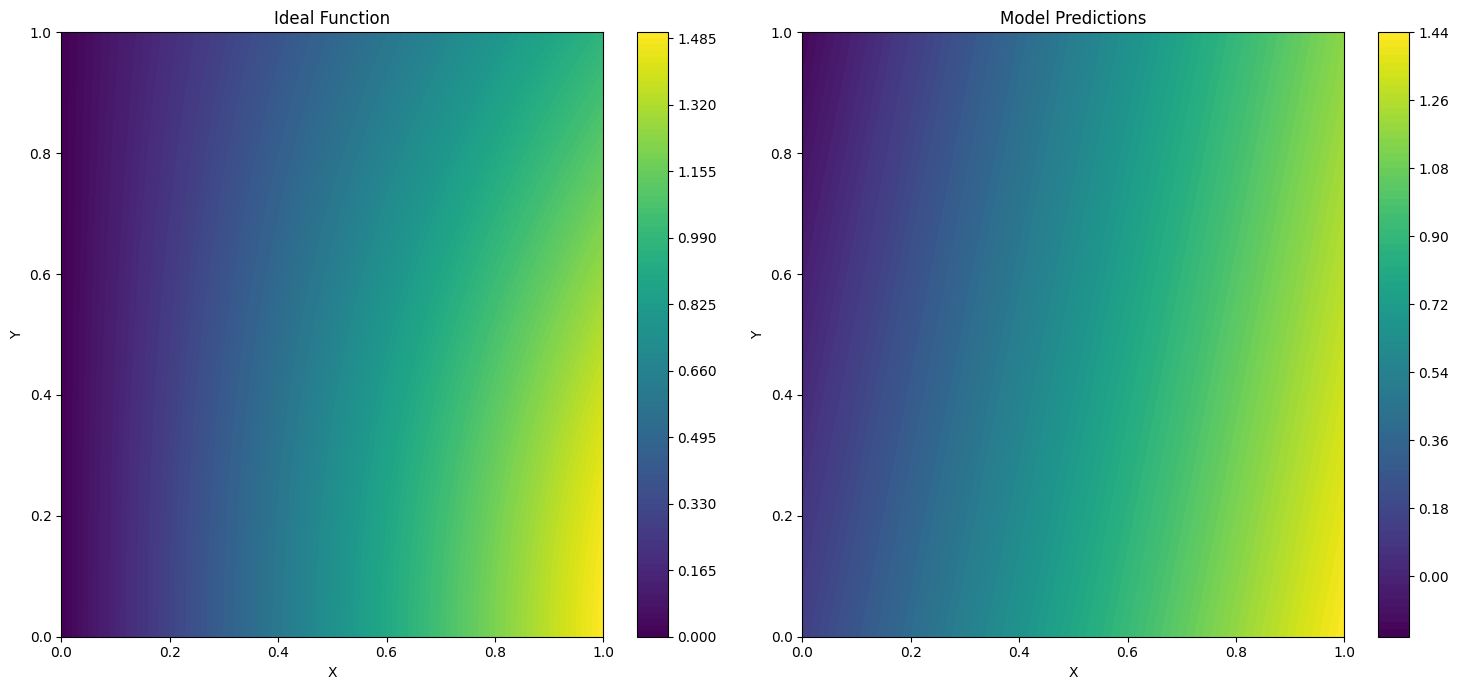

Training time: 86.85430209700098, mse: 0.0027939998653636537, r2: 0.9824782615126536


In [46]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_4, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [47]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 3.4667749019989826
MSE: 0.0081, r2: 0.9495
Simulated Annealing Metrics
Total run time in seconds: 13.626771753000867
MSE: 0.0031, r2: 0.9803
Adam Optimizer Metrics
Total run time in seconds: 81.13552230800087
MSE: 0.0028, r2: 0.9822
SGD Optimizer Metrics
Total run time in seconds: 86.91400257799978
MSE: 0.0028, r2: 0.9825
AdaGrad Optimizer Metrics
Total run time in seconds: 86.85430209700098
MSE: 0.0028, r2: 0.9825
Array of time for quantum in each training/retraining: [16.01232805600037, 3.464285203999266, 3.4707357430006884, 3.4667749019989826], total time: 26.414123904999308
Array of time for simulated in each training/retraining: [26.13870004599994, 14.026644038000086, 19.85474293200059, 13.626771753000867], total time: 73.64685876900148
Array of time for adam in each training/retraining: [69.50981463300013, 76.82246470799873, 95.413181979, 81.13552230800087], total time: 322.88098362799974
Array of time for SDG in each training

# Adding a few more datapoints for dataset 5

In [48]:
dataset_4 = dataset
X_4 = X
y_4 = 1
x_data_4 = x_data
y_data_4 = y_data
z_data_4 = z_data

In [49]:
dataset = dataset_split4
X = dataset['train_input']
y = dataset['train_label']
x_data = X[:, 0].numpy()
y_data = X[:, 1].numpy()
z_data = y[:, 0].numpy()

In [50]:
start_time_quantum_part1 = time.perf_counter()
# Call the C++ function and unpack the returned values
result = quantum_kan.compute_mse_with_penalty(
    d1=degree1, d2=degree2, d3=degree3,
    m1=m1, m2=m2, m3=m3,
    penalty_multiplier=penalty_multiplier,
    bias_coefficient=bias_coefficient,
    is_fractional=is_fractional,
    x_data=x_data.tolist(),
    y_data=y_data.tolist(),
    z_data=z_data.tolist(),
    load_filename=save_file4
)

mse_with_penalty_str, aux_dict_str, coeffs_plus1_str, coeffs_plus2_str, coeffs_plus3_str = result

flattened_coeffs_plus1_str = [item for sublist in coeffs_plus1_str for item in sublist]
flattened_coeffs_plus2_str = [item for sublist in coeffs_plus2_str for item in sublist]
flattened_coeffs_plus3_str = [item for sublist in coeffs_plus3_str for item in sublist]

# Define P variables (flatten the matrix of Binary variables to a list)
Solving_for_vars = flattened_coeffs_plus1_str[:] + flattened_coeffs_plus2_str[:] + flattened_coeffs_plus3_str[:]

for aux_var, aux_expr in aux_dict_str.items():
    Solving_for_vars.append(aux_var)
    
coefficients_plus_1 = Array.create('coeff_plus_1', shape=(num_basis_funcs_1, m1), vartype='BINARY')
coefficients_plus_2 = Array.create('coeff_plus_2', shape=(num_basis_funcs_2, m2), vartype='BINARY')
coefficients_plus_3 = Array.create('coeff_plus_3', shape=(num_basis_funcs_3, m3), vartype='BINARY')
num_aux = len(aux_dict_str)
coefficients_aux = Array.create('aux', shape=(num_aux,), vartype='BINARY')

# Convert to numpy arrays and concatenate
coefficients_plus_1_np = np.array(coefficients_plus_1)
# coefficients_minus_1_np = np.array(coefficients_minus_1)

coefficients_plus_2_np = np.array(coefficients_plus_2)
# coefficients_minus_2_np = np.array(coefficients_minus_2)
coefficients_plus_3_np = np.array(coefficients_plus_3)

coefficients_aux_np = np.array(coefficients_aux)

pyqubo_coeffs_np = np.concatenate((coefficients_plus_1_np, coefficients_plus_2_np, coefficients_plus_3_np, coefficients_aux_np), axis=None)

# Create a mapping from sympy variable names to pyqubo variables
sympy_to_pyqubo_map = {}
num_minus = 0
num_plus = 0
index = 0
# Mapping for P variables
for var in sorted(Solving_for_vars):
    var = str(var)
    if '_' in var:
        parts = var.split('_')
        prefix = f"{parts[0]}_{parts[2]}"
        i = int(parts[1])
        j = int(parts[3])
        if prefix == 'P1_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_1[i, j]
        elif prefix == 'P2_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_2[i, j]
        elif prefix == 'P3_plus':
            sympy_to_pyqubo_map[f"{var}"] = coefficients_plus_3[i, j]

# Mapping for AUX variables
aux_var_to_index = {var: idx for idx, var in enumerate(aux_dict_str.keys())}
for aux_var in aux_dict_str.keys():
    sympy_to_pyqubo_map[f"{aux_var}"] = coefficients_aux[aux_var_to_index[aux_var]]
        
pyqubo_sse = convert_sympy_to_pyqubo(mse_with_penalty_str, sympy_to_pyqubo_map)
# Compile QUBO model
model = pyqubo_sse.compile()
qubo, offset = model.to_qubo()
bqm = BinaryQuadraticModel.from_qubo(qubo)
chain_strength = uniform_torque_compensation(bqm) #* 2.0

end_time_quantum_part1 = time.perf_counter()

In [51]:
time_quantum_part1 = end_time_quantum_part1 - start_time_quantum_part1
print(f"Time spent on quantum part 1: {time_quantum_part1}")  # will print the elapsed time in seconds

Time spent on quantum part 1: 0.49213295799927437


In [52]:
# Combine datasets
combined_train_input = torch.cat((dataset_4['train_input'], dataset_3['train_input'], dataset_2['train_input'], dataset_1['train_input'], dataset['train_input']), dim=0)
combined_train_label = torch.cat((dataset_3['train_label'], dataset_3['train_label'], dataset_2['train_label'], dataset_1['train_label'], dataset['train_label']), dim=0)
combined_test_input = torch.cat((dataset_4['test_input'], dataset_3['test_input'], dataset_2['test_input'], dataset_1['test_input'], dataset['test_input']), dim=0)
combined_test_label = torch.cat((dataset_4['test_label'], dataset_3['test_label'], dataset_2['test_label'], dataset_1['test_label'], dataset['test_label']), dim=0)
combined_dataset_5 = {
    'train_input': combined_train_input,
    'train_label': combined_train_label,
    'test_input': combined_test_input,
    'test_label': combined_test_label
}

Timing Information:
qpu_access_time: 140998 microseconds
charge_time: 2994573 microseconds
run_time: 2994573 microseconds
problem_id: f971f082-63a2-4819-b79b-de947ed5b6ec microseconds

QPU Access Time: 140998 microseconds

Total D-Wave Run Time Including Setup: 2994573 microseconds
Time spent on hybrid part 2: 2.994573
Time spent on part 3: 0.0006488800008810358
Time spent on optimization: 3.4873548380001553
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.5, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX3

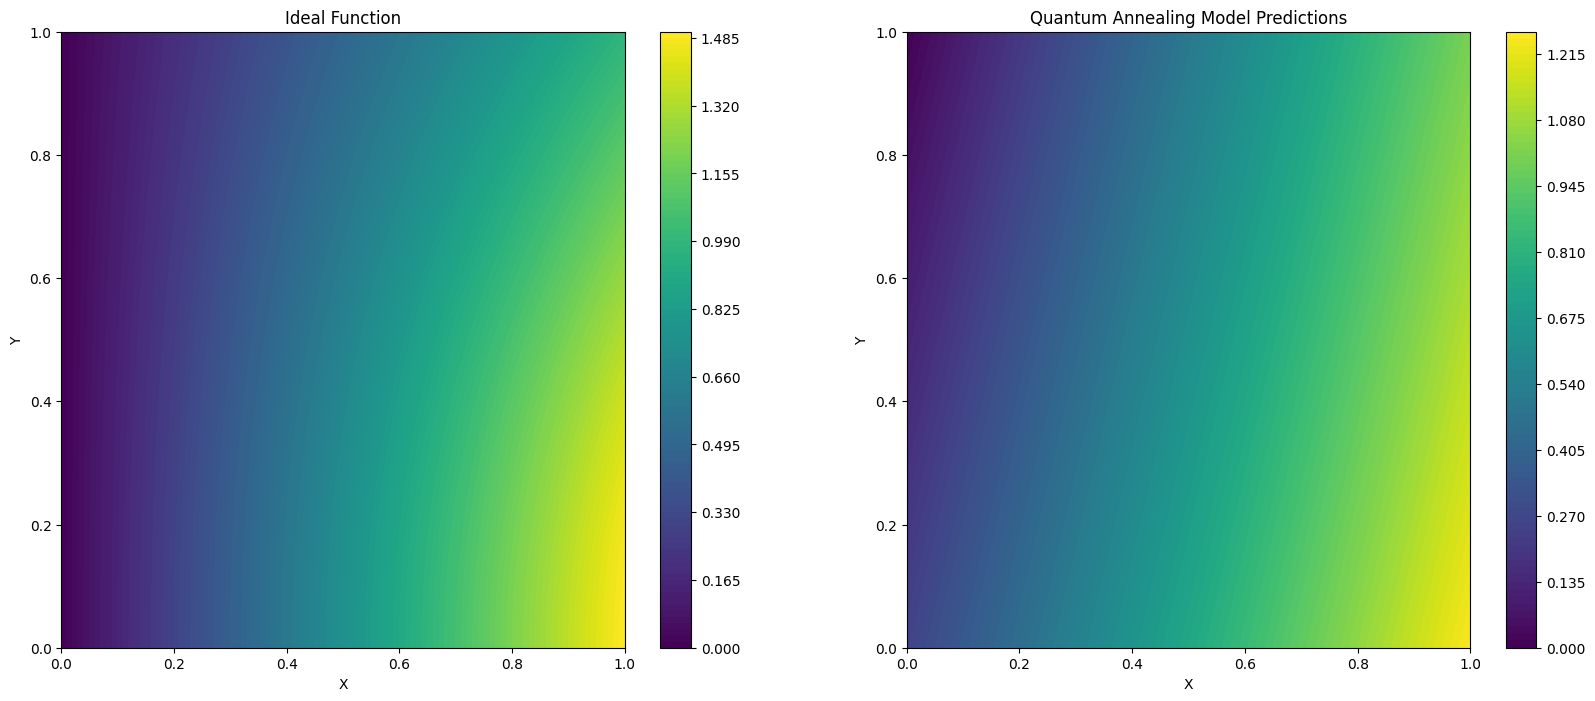

In [53]:
quantum_time_part2, quantum_time_part3, quantum_total_time_optimization, quantum_mse, quantum_r2 = run_annealing("HQA", sampler, bqm, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat)

Time spent on simulated part 2: 13.986382021999816
Time spent on part 3: 0.0013961510012450162
Time spent on optimization: 14.479911131000335
optimized_coefficients_1: [1, 0]
optimized_coefficients_2: [0.25, 0.5]
optimized_coefficients_3: [1.75, 0.5]
AUX54: Correct
AUX17: Correct
AUX6: Correct
AUX52: Correct
AUX9: Correct
AUX36: Correct
AUX1: Correct
AUX40: Correct
AUX19: Correct
AUX10: Correct
AUX43: Correct
AUX29: Correct
AUX41: Correct
AUX55: Correct
AUX31: Correct
AUX57: Correct
AUX49: Correct
AUX53: Correct
AUX50: Correct
AUX44: Correct
AUX46: Correct
AUX45: Correct
AUX47: Correct
AUX30: Correct
AUX34: Correct
AUX13: Correct
AUX35: Correct
AUX14: Correct
AUX22: Correct
AUX21: Correct
AUX16: Correct
AUX5: Correct
AUX33: Correct
AUX20: Correct
AUX18: Correct
AUX42: Correct
AUX24: Correct
AUX28: Correct
AUX2: Correct
AUX27: Correct
AUX0: Correct
AUX39: Correct
AUX8: Correct
AUX12: Correct
AUX37: Correct
AUX38: Correct
AUX26: Correct
AUX4: Correct
AUX23: Correct
AUX51: Correct
AUX25: 

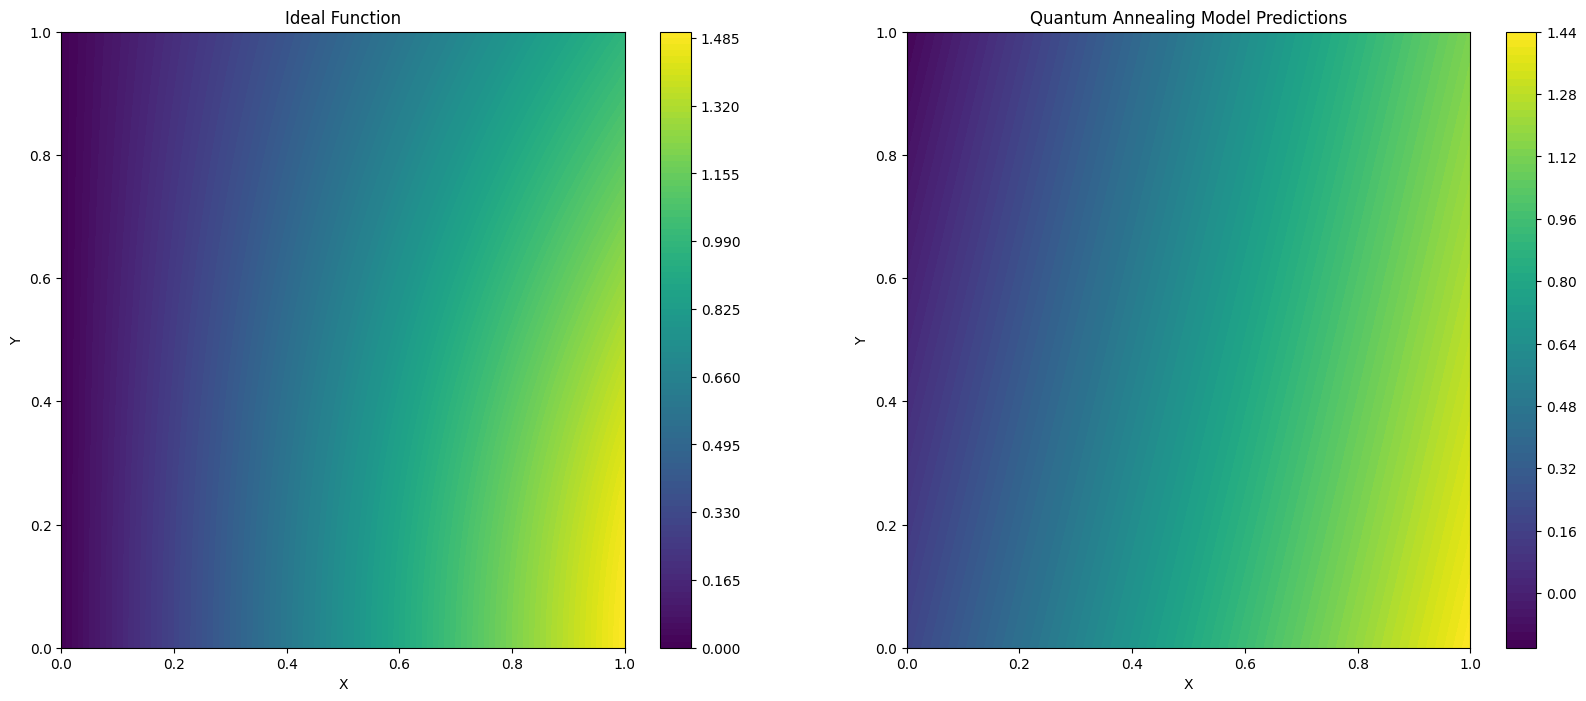

In [54]:
simulated_time_part2, simulated_time_part3, simulated_total_time_optimization, simulated_mse, simulated_r2 = run_annealing("SA", simulated_sampler, qubo, chain_strength, time_quantum_part1, num_basis_funcs_1, num_basis_funcs_2, num_basis_funcs_3, m1, m2, m3, num_aux, sympy_to_pyqubo_map, aux_dict_str, bias_coefficient, T, U, Z_ideal, Z_ideal_flat, num_reads=10000)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:25<00:00,  1.19s/it]


Training time in seconds of lr=0.05: 85.38365007200082
Learning Rate: 0.05, Train MSE: 0.0028046936725739536, Train r2: 0.9824111984838769


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.20e+00 : 100%|███████| 72/72 [01:26<00:00,  1.20s/it]


Training time in seconds of lr=0.1: 86.55856605000008
Learning Rate: 0.1, Train MSE: 0.0035990152912016094, Train r2: 0.9774298468922125


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.50e+00 : 100%|███████| 72/72 [01:40<00:00,  1.39s/it]


Training time in seconds of lr=0.2: 100.44526976199995
Learning Rate: 0.2, Train MSE: 0.00291476759244977, Train r2: 0.9817209026602263
Best Learning Rate: 0.05 with Train MSE: 0.0028046936725739536


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:33<00:00,  1.30s/it]


Training time in seconds: 93.4200305810009
Layer 0 Bezier coefficients:
[[ 0.5773774  -0.9911919 ]
 [-0.27007198  0.31139076]]
Layer 1 Bezier coefficients:
[[ 0.44169503 -0.14633052]]


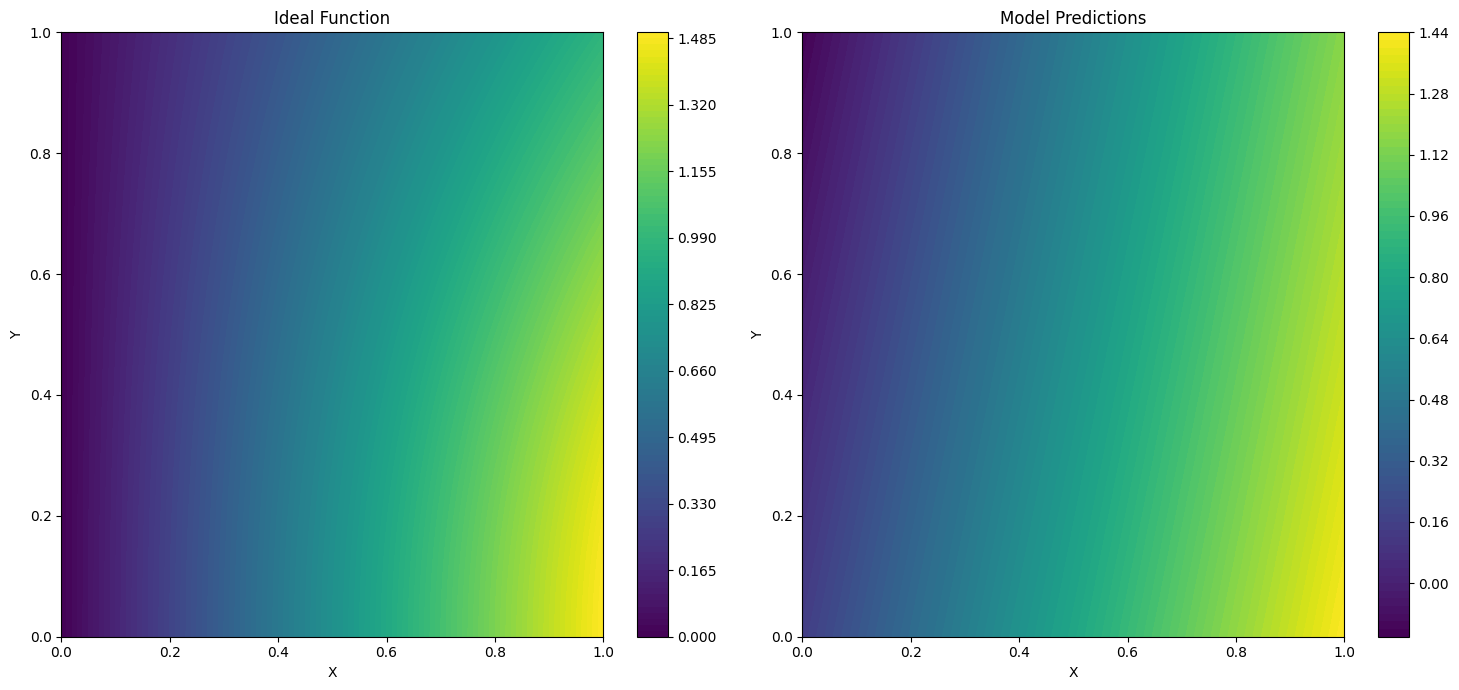

Training time: 93.4200305810009, mse: 0.0028050113967227385, r2: 0.9824092059714523


In [55]:
time_best_lr_adam, mse_adam, r2_adam = train_classical_optimizer(combined_dataset_5, degrees, "Adam", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 2.12e-01 | test loss: nan | reg: 2.67e+00 : 100%|███████| 72/72 [01:34<00:00,  1.31s/it]


Training time in seconds of lr=0.05: 94.20508036300089
Learning Rate: 0.05, Train MSE: 0.03725704260776504, Train r2: 0.7663535473004708


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.28e+00 : 100%|███████| 72/72 [01:31<00:00,  1.27s/it]


Training time in seconds of lr=0.1: 91.15576897900064
Learning Rate: 0.1, Train MSE: 0.0033498716786028123, Train r2: 0.978992276897978


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:30<00:00,  1.26s/it]


Training time in seconds of lr=0.2: 90.75270148399977
Learning Rate: 0.2, Train MSE: 0.0030457913363624188, Train r2: 0.9808992262511003
Best Learning Rate: 0.2 with Train MSE: 0.0030457913363624188


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.26e+00 : 100%|███████| 72/72 [01:35<00:00,  1.32s/it]


Training time in seconds: 95.06956388300023
Layer 0 Bezier coefficients:
[[ 0.56849027 -0.4480895 ]
 [-0.07605699  0.1869492 ]]
Layer 1 Bezier coefficients:
[[ 0.6606705  -0.18558782]]


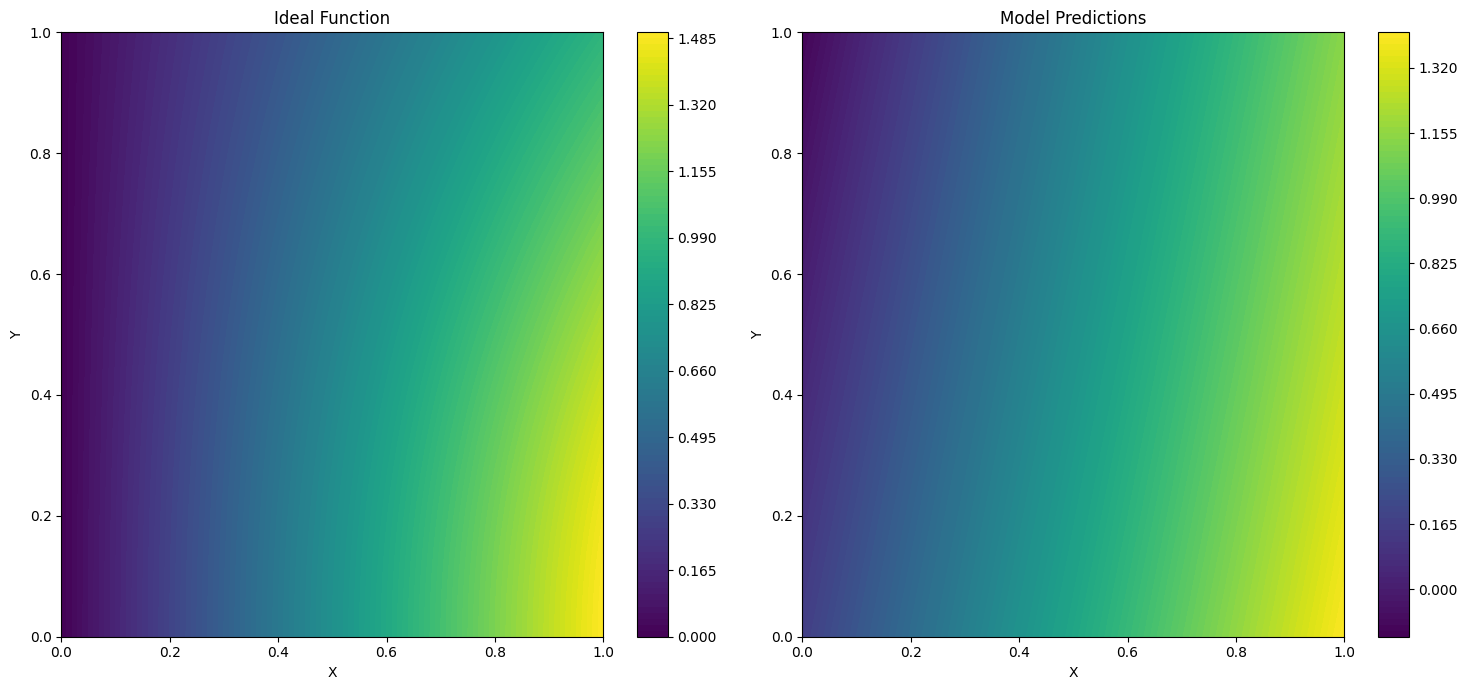

Training time: 95.06956388300023, mse: 0.003045798139992002, r2: 0.9808991835841625


In [56]:
time_best_lr_sgd, mse_sgd, r2_sgd = train_classical_optimizer(combined_dataset_5, degrees, "SGD", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.21e-01 | test loss: nan | reg: 2.44e+00 : 100%|███████| 72/72 [01:30<00:00,  1.26s/it]


Training time in seconds of lr=0.05: 90.89601539700016
Learning Rate: 0.05, Train MSE: 0.003505398245563801, Train r2: 0.9780169383276698


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.21e+00 : 100%|███████| 72/72 [01:32<00:00,  1.29s/it]


Training time in seconds of lr=0.1: 92.92202407699915
Learning Rate: 0.1, Train MSE: 0.003044842340383886, Train r2: 0.9809051775968993


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:39<00:00,  1.38s/it]


Training time in seconds of lr=0.2: 99.2515708409992
Learning Rate: 0.2, Train MSE: 0.003044896358220065, Train r2: 0.9809048388401188
Best Learning Rate: 0.1 with Train MSE: 0.003044842340383886


description:   0%|                                                           | 0/72 [00:00<?, ?it/s]/home/wtroy/.conda/envs/pykan-env/lib/python3.9/site-packages/qkan/KAN.py:246: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))
train loss: 1.20e-01 | test loss: nan | reg: 2.22e+00 : 100%|███████| 72/72 [01:36<00:00,  1.34s/it]


Training time in seconds: 96.32877805600037
Layer 0 Bezier coefficients:
[[ 0.43497974 -0.6455722 ]
 [-0.23810562  0.15887143]]
Layer 1 Bezier coefficients:
[[ 0.3602649 -0.116354 ]]


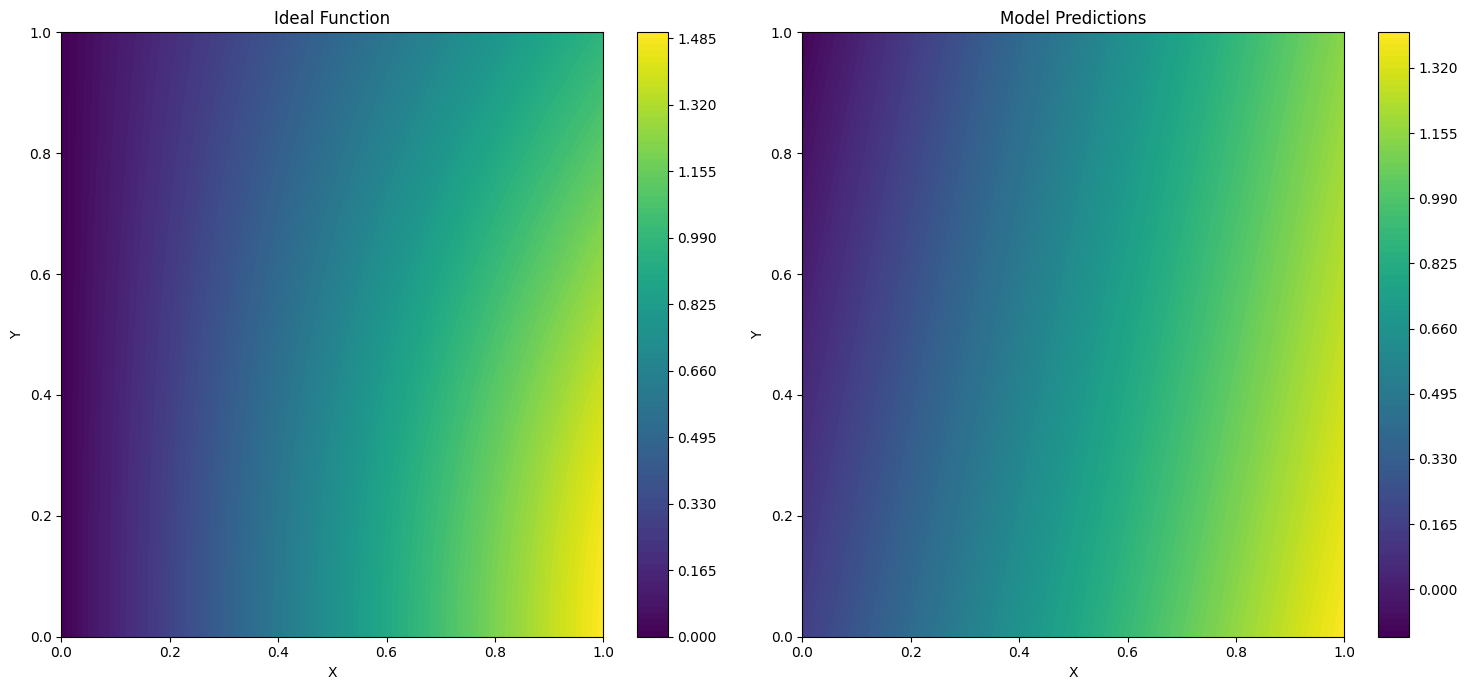

Training time: 96.32877805600037, mse: 0.003044843333717536, r2: 0.980905171367503


In [57]:
time_best_lr_adagrad, mse_adagrad, r2_adagrad = train_classical_optimizer(combined_dataset_5, degrees, "AdaGrad", adam_steps, learning_rates, T, U, Z_ideal, Z_ideal_flat)

In [58]:
total_time_quantum.append(quantum_total_time_optimization)
total_time_simulated.append(simulated_total_time_optimization)
total_time_adam.append(time_best_lr_adam)
total_time_sgd.append(time_best_lr_sgd)
total_time_adagrad.append(time_best_lr_adagrad)

print("Quantum Annealing Metrics:")
print(f"Total run time in seconds: {quantum_total_time_optimization}")
print(f"MSE: {quantum_mse:.4f}, r2: {quantum_r2:.4f}")

print("Simulated Annealing Metrics")
print(f"Total run time in seconds: {simulated_total_time_optimization}")
print(f"MSE: {simulated_mse:.4f}, r2: {simulated_r2:.4f}")

print("Adam Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adam}")
print(f"MSE: {mse_adam:.4f}, r2: {r2_adam:.4f}")

print("SGD Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_sgd}")
print(f"MSE: {mse_sgd:.4f}, r2: {r2_sgd:.4f}")

print("AdaGrad Optimizer Metrics")
print(f"Total run time in seconds: {time_best_lr_adagrad}")
print(f"MSE: {mse_adagrad:.4f}, r2: {r2_adagrad:.4f}")

# Total run times so far:
print(f"Array of time for quantum in each training/retraining: {total_time_quantum}, total time: {sum(total_time_quantum)}")
print(f"Array of time for simulated in each training/retraining: {total_time_simulated}, total time: {sum(total_time_simulated)}")
print(f"Array of time for adam in each training/retraining: {total_time_adam}, total time: {sum(total_time_adam)}")
print(f"Array of time for SDG in each training/retraining: {total_time_sgd}, total time: {sum(total_time_sgd)}")
print(f"Array of time for adagrad in each training/retraining: {total_time_adagrad}, total time: {sum(total_time_adagrad)}")

Quantum Annealing Metrics:
Total run time in seconds: 3.4873548380001553
MSE: 0.0112, r2: 0.9295
Simulated Annealing Metrics
Total run time in seconds: 14.479911131000335
MSE: 0.0031, r2: 0.9803
Adam Optimizer Metrics
Total run time in seconds: 93.4200305810009
MSE: 0.0028, r2: 0.9824
SGD Optimizer Metrics
Total run time in seconds: 95.06956388300023
MSE: 0.0030, r2: 0.9809
AdaGrad Optimizer Metrics
Total run time in seconds: 96.32877805600037
MSE: 0.0030, r2: 0.9809
Array of time for quantum in each training/retraining: [16.01232805600037, 3.464285203999266, 3.4707357430006884, 3.4667749019989826, 3.4873548380001553], total time: 29.901478742999462
Array of time for simulated in each training/retraining: [26.13870004599994, 14.026644038000086, 19.85474293200059, 13.626771753000867, 14.479911131000335], total time: 88.12676990000182
Array of time for adam in each training/retraining: [69.50981463300013, 76.82246470799873, 95.413181979, 81.13552230800087, 93.4200305810009], total time: 

# Save the datasets

In [59]:
import pickle

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset1.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 1 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset2.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 2 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset3.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 3 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset4.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 4 saved to {dataset_file}")

# Save the entire dataset as a pickle file
dataset_file = f'dataset_2_1_35_18_retraining_m1_1_dataset5.pkl'
with open(dataset_file, 'wb') as f:
    pickle.dump(dataset_1, f)

print(f"Dataset 5 saved to {dataset_file}")

Dataset 1 saved to dataset_2_1_35_18_retraining_m1_1_dataset1.pkl
Dataset 2 saved to dataset_2_1_35_18_retraining_m1_1_dataset2.pkl
Dataset 3 saved to dataset_2_1_35_18_retraining_m1_1_dataset3.pkl
Dataset 4 saved to dataset_2_1_35_18_retraining_m1_1_dataset4.pkl
Dataset 5 saved to dataset_2_1_35_18_retraining_m1_1_dataset5.pkl
